# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [13]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

(25, 28, 28, 1)


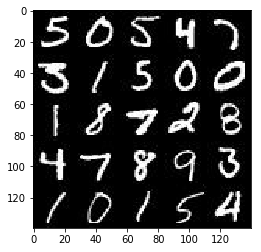

In [14]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')
print(mnist_images.shape) ###delete later

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

(25, 28, 28, 3)


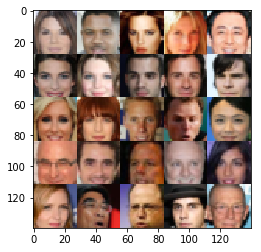

In [15]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))
print(mnist_images.shape)

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [16]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0


/home/ubuntu/anaconda3/envs/dlnd/lib/python3.6/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [17]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, shape=[None, image_width, image_height, \
                        image_channels], name='input_real')
    input_z = tf.placeholder(tf.float32, shape=[None, z_dim], name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [18]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    alpha = 0.1
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # First convolutional layer
        conv1 = tf.layers.conv2d(images, 56, 5, 2, 'SAME')
        conv1 = tf.maximum(alpha*conv1, conv1)
        
        # Second convolutional layer
        conv2 = tf.layers.conv2d(conv1, 112, 5, 2, 'SAME')
        conv2 = tf.layers.batch_normalization(conv2, training=True)
        conv2 = tf.maximum(alpha*conv2, conv2)
        
        # Third convolutional layer
        conv3 = tf.layers.conv2d(conv2, 224, 5, 2, 'SAME')
        conv3 = tf.layers.batch_normalization(conv3, training=True)
        conv3 = tf.maximum(alpha*conv3, conv3)
        
        # Output fully connected layer
        flat   = tf.reshape(conv3, (-1, 4*4*224))
        logits = tf.layers.dense(flat, 1)
        
        ### REVIEWER TIP ####
        # Apply dropout so that discriminator 
        # is less prone to learning the data distribution
        logits = tf.layers.dropout(logits, rate=0.5)
        
        output = tf.sigmoid(logits)
        
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [19]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    alpha = 0.1
    
    with tf.variable_scope('generator', reuse=not(is_train)):
        
        # Input fully connected layer
        fully = tf.layers.dense(z, 7*7*112)
        fully = tf.reshape(fully, (-1, 7, 7, 112))
        fully = tf.layers.batch_normalization(fully, training=is_train)
        fully = tf.maximum(alpha*fully, fully)
        
        # First convolutional layer
        conv1 = tf.layers.conv2d_transpose(fully, 56, 5, 2, 'SAME')
        conv1 = tf.layers.batch_normalization(conv1, training=is_train)
        conv1 = tf.maximum(alpha*conv1, conv1)
        
        # Output convolutional layer
        conv2 = tf.layers.conv2d_transpose(conv1, out_channel_dim, 5, 2, 'SAME')
        out = tf.tanh(conv2)

    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [20]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logit_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse = True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logit_real, labels = tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake, labels = tf.zeros_like(d_model_fake)))

    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake, labels = tf.ones_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
        
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [21]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [22]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [27]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):

# TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)

    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
        # TODO: Train Model
                steps+=1
        
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
            
                _ = sess.run(d_opt, feed_dict={input_real:batch_images, input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z:batch_z, lr:learning_rate, input_real:batch_images})
            
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Step: {}:".format(steps),
                          "Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                if steps % 100 == 0:
                    _ = show_generator_output(sess, 9, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Step: 10: Epoch 1/2... Discriminator Loss: 0.1934... Generator Loss: 2.0190
Step: 20: Epoch 1/2... Discriminator Loss: 0.2057... Generator Loss: 1.8904
Step: 30: Epoch 1/2... Discriminator Loss: 0.1540... Generator Loss: 2.1980
Step: 40: Epoch 1/2... Discriminator Loss: 2.3360... Generator Loss: 0.1262
Step: 50: Epoch 1/2... Discriminator Loss: 0.1822... Generator Loss: 2.7468
Step: 60: Epoch 1/2... Discriminator Loss: 0.2082... Generator Loss: 2.1445
Step: 70: Epoch 1/2... Discriminator Loss: 0.2019... Generator Loss: 2.1922
Step: 80: Epoch 1/2... Discriminator Loss: 1.6069... Generator Loss: 0.3551
Step: 90: Epoch 1/2... Discriminator Loss: 0.4624... Generator Loss: 1.5248
Step: 100: Epoch 1/2... Discriminator Loss: 0.4496... Generator Loss: 1.5481


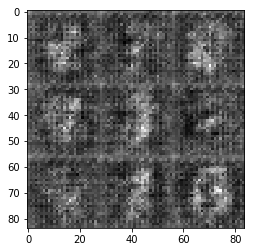

Step: 110: Epoch 1/2... Discriminator Loss: 0.2652... Generator Loss: 2.3652
Step: 120: Epoch 1/2... Discriminator Loss: 0.3564... Generator Loss: 2.5196
Step: 130: Epoch 1/2... Discriminator Loss: 0.5828... Generator Loss: 1.1906
Step: 140: Epoch 1/2... Discriminator Loss: 0.3903... Generator Loss: 2.7959
Step: 150: Epoch 1/2... Discriminator Loss: 0.4791... Generator Loss: 1.3385
Step: 160: Epoch 1/2... Discriminator Loss: 0.3368... Generator Loss: 1.6552
Step: 170: Epoch 1/2... Discriminator Loss: 0.6034... Generator Loss: 4.3502
Step: 180: Epoch 1/2... Discriminator Loss: 0.3053... Generator Loss: 1.7880
Step: 190: Epoch 1/2... Discriminator Loss: 0.3022... Generator Loss: 2.1703
Step: 200: Epoch 1/2... Discriminator Loss: 0.2829... Generator Loss: 2.0058


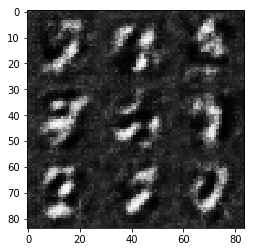

Step: 210: Epoch 1/2... Discriminator Loss: 0.2701... Generator Loss: 2.7155
Step: 220: Epoch 1/2... Discriminator Loss: 1.7643... Generator Loss: 0.2421
Step: 230: Epoch 1/2... Discriminator Loss: 0.2557... Generator Loss: 2.0984
Step: 240: Epoch 1/2... Discriminator Loss: 0.1950... Generator Loss: 2.2428
Step: 250: Epoch 1/2... Discriminator Loss: 0.1808... Generator Loss: 2.3792
Step: 260: Epoch 1/2... Discriminator Loss: 0.1869... Generator Loss: 2.2004
Step: 270: Epoch 1/2... Discriminator Loss: 0.1196... Generator Loss: 2.6684
Step: 280: Epoch 1/2... Discriminator Loss: 0.1595... Generator Loss: 2.3802
Step: 290: Epoch 1/2... Discriminator Loss: 0.1435... Generator Loss: 3.4284
Step: 300: Epoch 1/2... Discriminator Loss: 0.2151... Generator Loss: 2.2062


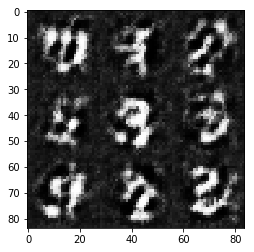

Step: 310: Epoch 1/2... Discriminator Loss: 0.2585... Generator Loss: 1.9845
Step: 320: Epoch 1/2... Discriminator Loss: 0.2197... Generator Loss: 2.0419
Step: 330: Epoch 1/2... Discriminator Loss: 0.1114... Generator Loss: 2.9175
Step: 340: Epoch 1/2... Discriminator Loss: 0.1416... Generator Loss: 2.6296
Step: 350: Epoch 1/2... Discriminator Loss: 0.1116... Generator Loss: 2.8936
Step: 360: Epoch 1/2... Discriminator Loss: 0.1098... Generator Loss: 2.9903
Step: 370: Epoch 1/2... Discriminator Loss: 0.1223... Generator Loss: 2.6580
Step: 380: Epoch 1/2... Discriminator Loss: 0.0944... Generator Loss: 3.1400
Step: 390: Epoch 1/2... Discriminator Loss: 0.1178... Generator Loss: 2.5180
Step: 400: Epoch 1/2... Discriminator Loss: 0.0946... Generator Loss: 3.0389


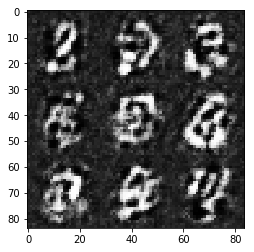

Step: 410: Epoch 1/2... Discriminator Loss: 0.0677... Generator Loss: 3.3233
Step: 420: Epoch 1/2... Discriminator Loss: 0.0705... Generator Loss: 3.5649
Step: 430: Epoch 1/2... Discriminator Loss: 0.2309... Generator Loss: 1.8278
Step: 440: Epoch 1/2... Discriminator Loss: 0.0775... Generator Loss: 3.1145
Step: 450: Epoch 1/2... Discriminator Loss: 0.0793... Generator Loss: 3.0907
Step: 460: Epoch 1/2... Discriminator Loss: 9.6167... Generator Loss: 10.4649
Step: 470: Epoch 1/2... Discriminator Loss: 0.5840... Generator Loss: 1.0870
Step: 480: Epoch 1/2... Discriminator Loss: 0.2889... Generator Loss: 2.0055
Step: 490: Epoch 1/2... Discriminator Loss: 0.5005... Generator Loss: 1.1537
Step: 500: Epoch 1/2... Discriminator Loss: 0.3226... Generator Loss: 1.6933


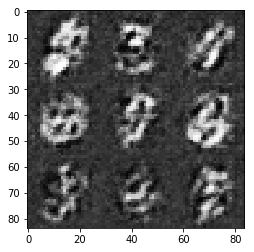

Step: 510: Epoch 1/2... Discriminator Loss: 0.2074... Generator Loss: 2.5237
Step: 520: Epoch 1/2... Discriminator Loss: 0.2363... Generator Loss: 2.2828
Step: 530: Epoch 1/2... Discriminator Loss: 0.2999... Generator Loss: 1.7767
Step: 540: Epoch 1/2... Discriminator Loss: 0.2810... Generator Loss: 1.8941
Step: 550: Epoch 1/2... Discriminator Loss: 0.2885... Generator Loss: 1.8162
Step: 560: Epoch 1/2... Discriminator Loss: 0.2314... Generator Loss: 1.9681
Step: 570: Epoch 1/2... Discriminator Loss: 0.2692... Generator Loss: 1.9107
Step: 580: Epoch 1/2... Discriminator Loss: 0.2040... Generator Loss: 2.3798
Step: 590: Epoch 1/2... Discriminator Loss: 0.2265... Generator Loss: 1.9523
Step: 600: Epoch 1/2... Discriminator Loss: 0.1452... Generator Loss: 2.6033


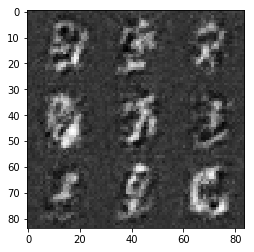

Step: 610: Epoch 1/2... Discriminator Loss: 0.2099... Generator Loss: 2.1892
Step: 620: Epoch 1/2... Discriminator Loss: 0.3138... Generator Loss: 1.5788
Step: 630: Epoch 1/2... Discriminator Loss: 0.2410... Generator Loss: 2.4965
Step: 640: Epoch 1/2... Discriminator Loss: 0.2575... Generator Loss: 2.0347
Step: 650: Epoch 1/2... Discriminator Loss: 0.1830... Generator Loss: 2.3086
Step: 660: Epoch 1/2... Discriminator Loss: 0.1543... Generator Loss: 2.4874
Step: 670: Epoch 1/2... Discriminator Loss: 0.1701... Generator Loss: 2.3019
Step: 680: Epoch 1/2... Discriminator Loss: 0.2191... Generator Loss: 1.9685
Step: 690: Epoch 1/2... Discriminator Loss: 0.2455... Generator Loss: 1.9876
Step: 700: Epoch 1/2... Discriminator Loss: 0.1516... Generator Loss: 2.4124


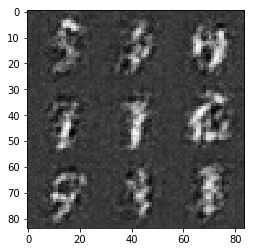

Step: 710: Epoch 1/2... Discriminator Loss: 0.1878... Generator Loss: 2.1038
Step: 720: Epoch 1/2... Discriminator Loss: 0.1738... Generator Loss: 2.2904
Step: 730: Epoch 1/2... Discriminator Loss: 0.1547... Generator Loss: 2.4433
Step: 740: Epoch 1/2... Discriminator Loss: 0.1373... Generator Loss: 2.6235
Step: 750: Epoch 1/2... Discriminator Loss: 0.1139... Generator Loss: 2.8504
Step: 760: Epoch 1/2... Discriminator Loss: 0.1305... Generator Loss: 2.5702
Step: 770: Epoch 1/2... Discriminator Loss: 0.1051... Generator Loss: 2.8202
Step: 780: Epoch 1/2... Discriminator Loss: 0.1409... Generator Loss: 2.5642
Step: 790: Epoch 1/2... Discriminator Loss: 0.1947... Generator Loss: 2.0171
Step: 800: Epoch 1/2... Discriminator Loss: 0.0876... Generator Loss: 3.1788


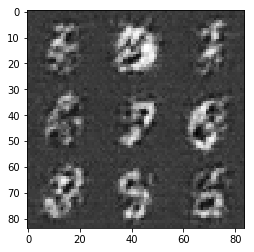

Step: 810: Epoch 1/2... Discriminator Loss: 0.3419... Generator Loss: 1.5701
Step: 820: Epoch 1/2... Discriminator Loss: 0.0814... Generator Loss: 3.2493
Step: 830: Epoch 1/2... Discriminator Loss: 0.2083... Generator Loss: 3.7677
Step: 840: Epoch 1/2... Discriminator Loss: 0.2108... Generator Loss: 2.0761
Step: 850: Epoch 1/2... Discriminator Loss: 0.1082... Generator Loss: 2.9367
Step: 860: Epoch 1/2... Discriminator Loss: 0.0958... Generator Loss: 2.9979
Step: 870: Epoch 1/2... Discriminator Loss: 0.0609... Generator Loss: 3.5703
Step: 880: Epoch 1/2... Discriminator Loss: 0.0730... Generator Loss: 3.1671
Step: 890: Epoch 1/2... Discriminator Loss: 0.1736... Generator Loss: 2.3760
Step: 900: Epoch 1/2... Discriminator Loss: 0.1281... Generator Loss: 2.9192


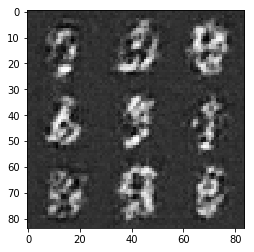

Step: 910: Epoch 1/2... Discriminator Loss: 0.0685... Generator Loss: 3.2561
Step: 920: Epoch 1/2... Discriminator Loss: 0.1728... Generator Loss: 2.2899
Step: 930: Epoch 1/2... Discriminator Loss: 0.0863... Generator Loss: 2.9683
Step: 940: Epoch 1/2... Discriminator Loss: 0.1036... Generator Loss: 2.9460
Step: 950: Epoch 1/2... Discriminator Loss: 0.1444... Generator Loss: 2.7682
Step: 960: Epoch 1/2... Discriminator Loss: 0.0532... Generator Loss: 4.0097
Step: 970: Epoch 1/2... Discriminator Loss: 0.0768... Generator Loss: 3.2483
Step: 980: Epoch 1/2... Discriminator Loss: 0.0747... Generator Loss: 3.1848
Step: 990: Epoch 1/2... Discriminator Loss: 0.0889... Generator Loss: 3.2512
Step: 1000: Epoch 1/2... Discriminator Loss: 0.0799... Generator Loss: 3.4741


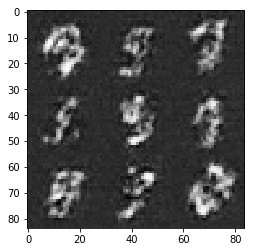

Step: 1010: Epoch 1/2... Discriminator Loss: 0.1100... Generator Loss: 2.6966
Step: 1020: Epoch 1/2... Discriminator Loss: 0.0802... Generator Loss: 2.9891
Step: 1030: Epoch 1/2... Discriminator Loss: 0.1308... Generator Loss: 2.6503
Step: 1040: Epoch 1/2... Discriminator Loss: 0.0959... Generator Loss: 3.0487
Step: 1050: Epoch 1/2... Discriminator Loss: 0.1307... Generator Loss: 2.6054
Step: 1060: Epoch 1/2... Discriminator Loss: 0.1909... Generator Loss: 2.1578
Step: 1070: Epoch 1/2... Discriminator Loss: 0.0713... Generator Loss: 3.3309
Step: 1080: Epoch 1/2... Discriminator Loss: 0.0898... Generator Loss: 3.0313
Step: 1090: Epoch 1/2... Discriminator Loss: 0.1003... Generator Loss: 3.2792
Step: 1100: Epoch 1/2... Discriminator Loss: 0.0815... Generator Loss: 3.0236


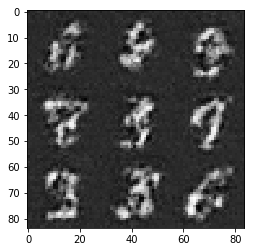

Step: 1110: Epoch 1/2... Discriminator Loss: 0.0525... Generator Loss: 3.6944
Step: 1120: Epoch 1/2... Discriminator Loss: 0.1289... Generator Loss: 2.4944
Step: 1130: Epoch 1/2... Discriminator Loss: 0.0751... Generator Loss: 3.3632
Step: 1140: Epoch 1/2... Discriminator Loss: 0.0612... Generator Loss: 3.4726
Step: 1150: Epoch 1/2... Discriminator Loss: 0.1000... Generator Loss: 2.9497
Step: 1160: Epoch 1/2... Discriminator Loss: 0.1037... Generator Loss: 2.7820
Step: 1170: Epoch 1/2... Discriminator Loss: 0.0727... Generator Loss: 3.1507
Step: 1180: Epoch 1/2... Discriminator Loss: 0.0542... Generator Loss: 3.6850
Step: 1190: Epoch 1/2... Discriminator Loss: 0.0992... Generator Loss: 3.1767
Step: 1200: Epoch 1/2... Discriminator Loss: 0.0964... Generator Loss: 2.9508


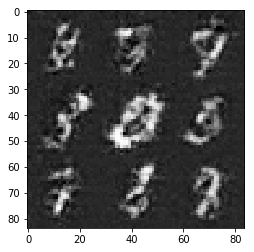

Step: 1210: Epoch 1/2... Discriminator Loss: 0.1089... Generator Loss: 2.9760
Step: 1220: Epoch 1/2... Discriminator Loss: 0.0567... Generator Loss: 3.5876
Step: 1230: Epoch 1/2... Discriminator Loss: 0.0700... Generator Loss: 3.5886
Step: 1240: Epoch 1/2... Discriminator Loss: 0.0597... Generator Loss: 3.6214
Step: 1250: Epoch 1/2... Discriminator Loss: 0.0945... Generator Loss: 2.9481
Step: 1260: Epoch 1/2... Discriminator Loss: 0.1128... Generator Loss: 2.7309
Step: 1270: Epoch 1/2... Discriminator Loss: 2.7472... Generator Loss: 0.1965
Step: 1280: Epoch 1/2... Discriminator Loss: 0.5053... Generator Loss: 1.2863
Step: 1290: Epoch 1/2... Discriminator Loss: 0.3150... Generator Loss: 2.0201
Step: 1300: Epoch 1/2... Discriminator Loss: 0.2073... Generator Loss: 2.1777


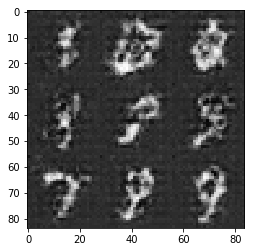

Step: 1310: Epoch 1/2... Discriminator Loss: 0.2346... Generator Loss: 2.1811
Step: 1320: Epoch 1/2... Discriminator Loss: 0.1512... Generator Loss: 2.5744
Step: 1330: Epoch 1/2... Discriminator Loss: 0.1464... Generator Loss: 2.6860
Step: 1340: Epoch 1/2... Discriminator Loss: 0.1420... Generator Loss: 2.5448
Step: 1350: Epoch 1/2... Discriminator Loss: 0.1775... Generator Loss: 2.3132
Step: 1360: Epoch 1/2... Discriminator Loss: 0.1848... Generator Loss: 2.0921
Step: 1370: Epoch 1/2... Discriminator Loss: 0.1627... Generator Loss: 2.4002
Step: 1380: Epoch 1/2... Discriminator Loss: 0.1763... Generator Loss: 2.1719
Step: 1390: Epoch 1/2... Discriminator Loss: 0.0464... Generator Loss: 3.6759
Step: 1400: Epoch 1/2... Discriminator Loss: 0.0678... Generator Loss: 3.1350


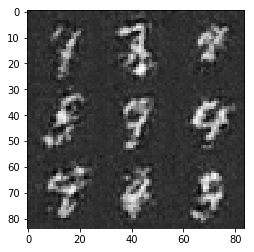

Step: 1410: Epoch 1/2... Discriminator Loss: 0.1210... Generator Loss: 2.5964
Step: 1420: Epoch 1/2... Discriminator Loss: 0.0696... Generator Loss: 3.2442
Step: 1430: Epoch 1/2... Discriminator Loss: 0.1335... Generator Loss: 2.5177
Step: 1440: Epoch 1/2... Discriminator Loss: 0.0733... Generator Loss: 3.1217
Step: 1450: Epoch 1/2... Discriminator Loss: 0.0786... Generator Loss: 2.8665
Step: 1460: Epoch 1/2... Discriminator Loss: 0.0506... Generator Loss: 3.6328
Step: 1470: Epoch 1/2... Discriminator Loss: 0.0351... Generator Loss: 3.9268
Step: 1480: Epoch 1/2... Discriminator Loss: 0.0838... Generator Loss: 2.9754
Step: 1490: Epoch 1/2... Discriminator Loss: 0.0998... Generator Loss: 2.6267
Step: 1500: Epoch 1/2... Discriminator Loss: 0.0776... Generator Loss: 2.9623


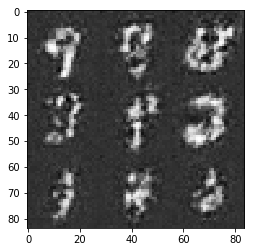

Step: 1510: Epoch 1/2... Discriminator Loss: 0.1023... Generator Loss: 2.7544
Step: 1520: Epoch 1/2... Discriminator Loss: 0.0886... Generator Loss: 3.0991
Step: 1530: Epoch 1/2... Discriminator Loss: 0.0880... Generator Loss: 2.8712
Step: 1540: Epoch 1/2... Discriminator Loss: 0.0881... Generator Loss: 2.8989
Step: 1550: Epoch 1/2... Discriminator Loss: 0.0362... Generator Loss: 3.9829
Step: 1560: Epoch 1/2... Discriminator Loss: 0.0936... Generator Loss: 3.0856
Step: 1570: Epoch 1/2... Discriminator Loss: 0.0912... Generator Loss: 3.2662
Step: 1580: Epoch 1/2... Discriminator Loss: 0.0441... Generator Loss: 3.7332
Step: 1590: Epoch 1/2... Discriminator Loss: 0.0908... Generator Loss: 2.9516
Step: 1600: Epoch 1/2... Discriminator Loss: 0.1129... Generator Loss: 2.6281


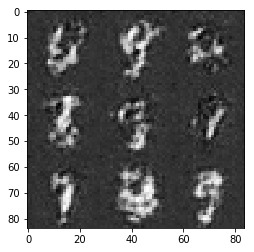

Step: 1610: Epoch 1/2... Discriminator Loss: 0.0679... Generator Loss: 3.1475
Step: 1620: Epoch 1/2... Discriminator Loss: 0.0704... Generator Loss: 3.3186
Step: 1630: Epoch 1/2... Discriminator Loss: 0.0505... Generator Loss: 3.6177
Step: 1640: Epoch 1/2... Discriminator Loss: 0.0396... Generator Loss: 3.7244
Step: 1650: Epoch 1/2... Discriminator Loss: 0.0750... Generator Loss: 3.2051
Step: 1660: Epoch 1/2... Discriminator Loss: 0.1371... Generator Loss: 2.4257
Step: 1670: Epoch 1/2... Discriminator Loss: 0.1138... Generator Loss: 2.8808
Step: 1680: Epoch 1/2... Discriminator Loss: 0.2233... Generator Loss: 2.0401
Step: 1690: Epoch 1/2... Discriminator Loss: 0.0649... Generator Loss: 3.3502
Step: 1700: Epoch 1/2... Discriminator Loss: 0.1297... Generator Loss: 2.5553


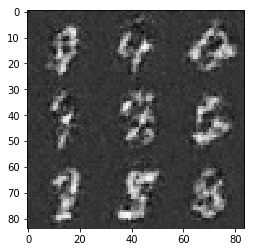

Step: 1710: Epoch 1/2... Discriminator Loss: 0.1173... Generator Loss: 2.6496
Step: 1720: Epoch 1/2... Discriminator Loss: 0.0799... Generator Loss: 3.2090
Step: 1730: Epoch 1/2... Discriminator Loss: 0.1134... Generator Loss: 2.6400
Step: 1740: Epoch 1/2... Discriminator Loss: 0.0156... Generator Loss: 4.7564
Step: 1750: Epoch 1/2... Discriminator Loss: 0.1602... Generator Loss: 2.4081
Step: 1760: Epoch 1/2... Discriminator Loss: 0.0772... Generator Loss: 3.4325
Step: 1770: Epoch 1/2... Discriminator Loss: 0.0834... Generator Loss: 3.1150
Step: 1780: Epoch 1/2... Discriminator Loss: 0.1606... Generator Loss: 2.2794
Step: 1790: Epoch 1/2... Discriminator Loss: 0.1595... Generator Loss: 2.5260
Step: 1800: Epoch 1/2... Discriminator Loss: 0.0427... Generator Loss: 3.6573


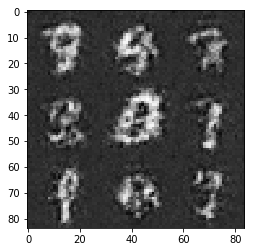

Step: 1810: Epoch 1/2... Discriminator Loss: 0.0582... Generator Loss: 3.4063
Step: 1820: Epoch 1/2... Discriminator Loss: 0.0585... Generator Loss: 3.4447
Step: 1830: Epoch 1/2... Discriminator Loss: 0.0739... Generator Loss: 3.2737
Step: 1840: Epoch 1/2... Discriminator Loss: 0.0929... Generator Loss: 2.8055
Step: 1850: Epoch 1/2... Discriminator Loss: 0.0966... Generator Loss: 2.9216
Step: 1860: Epoch 1/2... Discriminator Loss: 0.0751... Generator Loss: 3.0784
Step: 1870: Epoch 1/2... Discriminator Loss: 0.3342... Generator Loss: 1.6791
Step: 1880: Epoch 2/2... Discriminator Loss: 0.1363... Generator Loss: 2.5757
Step: 1890: Epoch 2/2... Discriminator Loss: 0.0876... Generator Loss: 2.9483
Step: 1900: Epoch 2/2... Discriminator Loss: 0.0915... Generator Loss: 2.8934


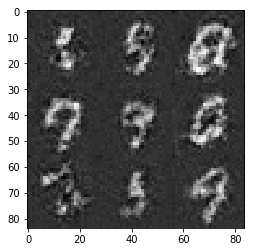

Step: 1910: Epoch 2/2... Discriminator Loss: 0.1024... Generator Loss: 3.0189
Step: 1920: Epoch 2/2... Discriminator Loss: 0.0745... Generator Loss: 3.1422
Step: 1930: Epoch 2/2... Discriminator Loss: 0.0952... Generator Loss: 2.8910
Step: 1940: Epoch 2/2... Discriminator Loss: 0.0385... Generator Loss: 4.1165
Step: 1950: Epoch 2/2... Discriminator Loss: 0.1485... Generator Loss: 2.5817
Step: 1960: Epoch 2/2... Discriminator Loss: 0.1055... Generator Loss: 2.7629
Step: 1970: Epoch 2/2... Discriminator Loss: 0.1209... Generator Loss: 2.5335
Step: 1980: Epoch 2/2... Discriminator Loss: 0.1072... Generator Loss: 2.9273
Step: 1990: Epoch 2/2... Discriminator Loss: 0.1478... Generator Loss: 2.5538
Step: 2000: Epoch 2/2... Discriminator Loss: 0.0878... Generator Loss: 2.9592


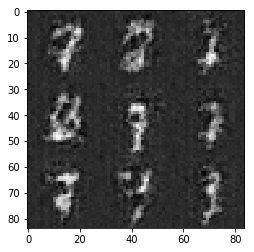

Step: 2010: Epoch 2/2... Discriminator Loss: 0.1751... Generator Loss: 2.2718
Step: 2020: Epoch 2/2... Discriminator Loss: 0.1858... Generator Loss: 2.3313
Step: 2030: Epoch 2/2... Discriminator Loss: 0.0866... Generator Loss: 3.2243
Step: 2040: Epoch 2/2... Discriminator Loss: 0.1081... Generator Loss: 2.6726
Step: 2050: Epoch 2/2... Discriminator Loss: 0.0333... Generator Loss: 4.1213
Step: 2060: Epoch 2/2... Discriminator Loss: 0.0706... Generator Loss: 3.3223
Step: 2070: Epoch 2/2... Discriminator Loss: 0.0219... Generator Loss: 4.3606
Step: 2080: Epoch 2/2... Discriminator Loss: 0.1978... Generator Loss: 2.4175
Step: 2090: Epoch 2/2... Discriminator Loss: 0.0373... Generator Loss: 4.0956
Step: 2100: Epoch 2/2... Discriminator Loss: 0.0802... Generator Loss: 3.3268


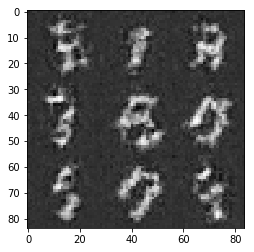

Step: 2110: Epoch 2/2... Discriminator Loss: 0.0704... Generator Loss: 3.3186
Step: 2120: Epoch 2/2... Discriminator Loss: 0.1668... Generator Loss: 2.3188
Step: 2130: Epoch 2/2... Discriminator Loss: 0.0596... Generator Loss: 3.3496
Step: 2140: Epoch 2/2... Discriminator Loss: 0.1080... Generator Loss: 2.8650
Step: 2150: Epoch 2/2... Discriminator Loss: 0.1231... Generator Loss: 2.7922
Step: 2160: Epoch 2/2... Discriminator Loss: 0.1072... Generator Loss: 2.8381
Step: 2170: Epoch 2/2... Discriminator Loss: 0.0695... Generator Loss: 3.5191
Step: 2180: Epoch 2/2... Discriminator Loss: 0.0543... Generator Loss: 3.4900
Step: 2190: Epoch 2/2... Discriminator Loss: 0.0581... Generator Loss: 3.5463
Step: 2200: Epoch 2/2... Discriminator Loss: 0.0522... Generator Loss: 3.7914


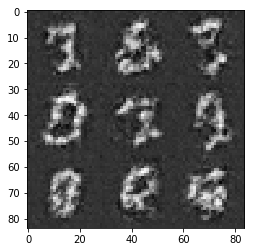

Step: 2210: Epoch 2/2... Discriminator Loss: 0.0618... Generator Loss: 3.1757
Step: 2220: Epoch 2/2... Discriminator Loss: 1.1172... Generator Loss: 1.1727
Step: 2230: Epoch 2/2... Discriminator Loss: 1.0219... Generator Loss: 1.5660
Step: 2240: Epoch 2/2... Discriminator Loss: 0.7479... Generator Loss: 1.1980
Step: 2250: Epoch 2/2... Discriminator Loss: 0.7676... Generator Loss: 1.6477
Step: 2260: Epoch 2/2... Discriminator Loss: 0.7214... Generator Loss: 1.3538
Step: 2270: Epoch 2/2... Discriminator Loss: 0.6701... Generator Loss: 1.2075
Step: 2280: Epoch 2/2... Discriminator Loss: 0.6488... Generator Loss: 1.3125
Step: 2290: Epoch 2/2... Discriminator Loss: 1.1958... Generator Loss: 2.0396
Step: 2300: Epoch 2/2... Discriminator Loss: 0.7335... Generator Loss: 1.6875


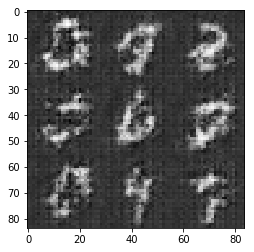

Step: 2310: Epoch 2/2... Discriminator Loss: 0.9131... Generator Loss: 0.6401
Step: 2320: Epoch 2/2... Discriminator Loss: 0.6108... Generator Loss: 1.1963
Step: 2330: Epoch 2/2... Discriminator Loss: 0.5586... Generator Loss: 2.3552
Step: 2340: Epoch 2/2... Discriminator Loss: 0.5714... Generator Loss: 1.4758
Step: 2350: Epoch 2/2... Discriminator Loss: 1.0238... Generator Loss: 0.6042
Step: 2360: Epoch 2/2... Discriminator Loss: 0.3375... Generator Loss: 2.9403
Step: 2370: Epoch 2/2... Discriminator Loss: 1.9635... Generator Loss: 0.2961
Step: 2380: Epoch 2/2... Discriminator Loss: 0.3793... Generator Loss: 1.6918
Step: 2390: Epoch 2/2... Discriminator Loss: 0.5033... Generator Loss: 1.1326
Step: 2400: Epoch 2/2... Discriminator Loss: 0.2090... Generator Loss: 2.3928


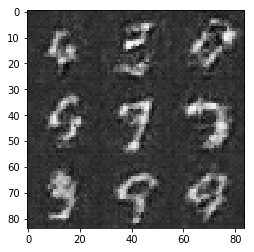

Step: 2410: Epoch 2/2... Discriminator Loss: 0.8230... Generator Loss: 5.1555
Step: 2420: Epoch 2/2... Discriminator Loss: 0.2449... Generator Loss: 2.0911
Step: 2430: Epoch 2/2... Discriminator Loss: 0.2152... Generator Loss: 2.2862
Step: 2440: Epoch 2/2... Discriminator Loss: 1.0553... Generator Loss: 6.7788
Step: 2450: Epoch 2/2... Discriminator Loss: 0.6996... Generator Loss: 0.7892
Step: 2460: Epoch 2/2... Discriminator Loss: 0.0982... Generator Loss: 3.2007
Step: 2470: Epoch 2/2... Discriminator Loss: 2.2041... Generator Loss: 0.2738
Step: 2480: Epoch 2/2... Discriminator Loss: 0.1575... Generator Loss: 2.5610
Step: 2490: Epoch 2/2... Discriminator Loss: 0.2034... Generator Loss: 2.1195
Step: 2500: Epoch 2/2... Discriminator Loss: 0.1912... Generator Loss: 2.1454


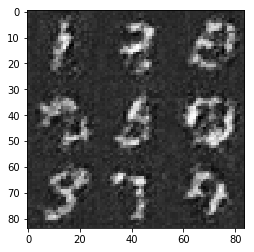

Step: 2510: Epoch 2/2... Discriminator Loss: 0.1444... Generator Loss: 2.6013
Step: 2520: Epoch 2/2... Discriminator Loss: 0.1322... Generator Loss: 2.6799
Step: 2530: Epoch 2/2... Discriminator Loss: 0.1729... Generator Loss: 2.5798
Step: 2540: Epoch 2/2... Discriminator Loss: 0.1555... Generator Loss: 2.4157
Step: 2550: Epoch 2/2... Discriminator Loss: 0.1338... Generator Loss: 2.7176
Step: 2560: Epoch 2/2... Discriminator Loss: 0.5383... Generator Loss: 1.2450
Step: 2570: Epoch 2/2... Discriminator Loss: 0.1595... Generator Loss: 2.4972
Step: 2580: Epoch 2/2... Discriminator Loss: 0.3346... Generator Loss: 1.6874
Step: 2590: Epoch 2/2... Discriminator Loss: 0.2271... Generator Loss: 2.0617
Step: 2600: Epoch 2/2... Discriminator Loss: 0.1058... Generator Loss: 2.7062


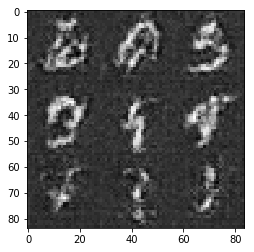

Step: 2610: Epoch 2/2... Discriminator Loss: 0.1336... Generator Loss: 2.6371
Step: 2620: Epoch 2/2... Discriminator Loss: 0.1148... Generator Loss: 2.6586
Step: 2630: Epoch 2/2... Discriminator Loss: 0.1340... Generator Loss: 2.7983
Step: 2640: Epoch 2/2... Discriminator Loss: 0.1647... Generator Loss: 2.3167
Step: 2650: Epoch 2/2... Discriminator Loss: 0.1033... Generator Loss: 2.9757
Step: 2660: Epoch 2/2... Discriminator Loss: 0.1970... Generator Loss: 2.3989
Step: 2670: Epoch 2/2... Discriminator Loss: 0.1219... Generator Loss: 2.7169
Step: 2680: Epoch 2/2... Discriminator Loss: 0.0999... Generator Loss: 2.8382
Step: 2690: Epoch 2/2... Discriminator Loss: 0.0703... Generator Loss: 3.0441
Step: 2700: Epoch 2/2... Discriminator Loss: 0.2065... Generator Loss: 2.0239


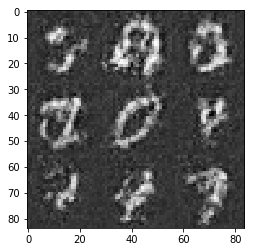

Step: 2710: Epoch 2/2... Discriminator Loss: 0.1518... Generator Loss: 2.3104
Step: 2720: Epoch 2/2... Discriminator Loss: 0.2113... Generator Loss: 1.9941
Step: 2730: Epoch 2/2... Discriminator Loss: 0.1020... Generator Loss: 2.7320
Step: 2740: Epoch 2/2... Discriminator Loss: 0.1939... Generator Loss: 2.3726
Step: 2750: Epoch 2/2... Discriminator Loss: 0.1231... Generator Loss: 2.7301
Step: 2760: Epoch 2/2... Discriminator Loss: 0.1760... Generator Loss: 2.2374
Step: 2770: Epoch 2/2... Discriminator Loss: 0.3433... Generator Loss: 1.7431
Step: 2780: Epoch 2/2... Discriminator Loss: 0.1407... Generator Loss: 2.4728
Step: 2790: Epoch 2/2... Discriminator Loss: 0.2073... Generator Loss: 2.3373
Step: 2800: Epoch 2/2... Discriminator Loss: 0.2714... Generator Loss: 2.2609


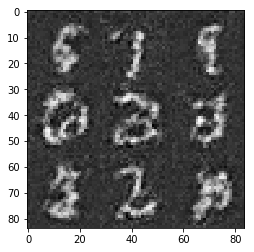

Step: 2810: Epoch 2/2... Discriminator Loss: 0.2059... Generator Loss: 2.1721
Step: 2820: Epoch 2/2... Discriminator Loss: 0.2093... Generator Loss: 2.1188
Step: 2830: Epoch 2/2... Discriminator Loss: 0.1982... Generator Loss: 2.4501
Step: 2840: Epoch 2/2... Discriminator Loss: 0.2368... Generator Loss: 2.0116
Step: 2850: Epoch 2/2... Discriminator Loss: 0.1760... Generator Loss: 2.4422
Step: 2860: Epoch 2/2... Discriminator Loss: 0.4191... Generator Loss: 1.3882
Step: 2870: Epoch 2/2... Discriminator Loss: 0.4804... Generator Loss: 1.3448
Step: 2880: Epoch 2/2... Discriminator Loss: 0.2422... Generator Loss: 1.9472
Step: 2890: Epoch 2/2... Discriminator Loss: 0.0766... Generator Loss: 3.0443
Step: 2900: Epoch 2/2... Discriminator Loss: 0.1544... Generator Loss: 2.4788


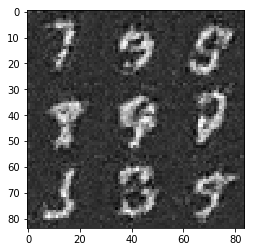

Step: 2910: Epoch 2/2... Discriminator Loss: 0.2260... Generator Loss: 2.1074
Step: 2920: Epoch 2/2... Discriminator Loss: 0.2548... Generator Loss: 2.0600
Step: 2930: Epoch 2/2... Discriminator Loss: 0.3861... Generator Loss: 1.5514
Step: 2940: Epoch 2/2... Discriminator Loss: 0.1527... Generator Loss: 2.3566
Step: 2950: Epoch 2/2... Discriminator Loss: 0.2798... Generator Loss: 2.0291
Step: 2960: Epoch 2/2... Discriminator Loss: 0.1699... Generator Loss: 2.4707
Step: 2970: Epoch 2/2... Discriminator Loss: 0.3096... Generator Loss: 1.6076
Step: 2980: Epoch 2/2... Discriminator Loss: 1.1995... Generator Loss: 0.7152
Step: 2990: Epoch 2/2... Discriminator Loss: 0.1864... Generator Loss: 2.3701
Step: 3000: Epoch 2/2... Discriminator Loss: 0.2355... Generator Loss: 2.4323


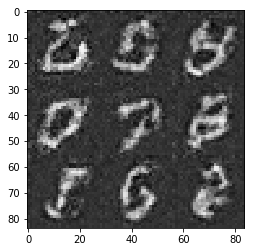

Step: 3010: Epoch 2/2... Discriminator Loss: 0.2424... Generator Loss: 1.9529
Step: 3020: Epoch 2/2... Discriminator Loss: 0.1731... Generator Loss: 2.5817
Step: 3030: Epoch 2/2... Discriminator Loss: 0.0649... Generator Loss: 3.1507
Step: 3040: Epoch 2/2... Discriminator Loss: 0.1704... Generator Loss: 2.5285
Step: 3050: Epoch 2/2... Discriminator Loss: 0.1679... Generator Loss: 2.6241
Step: 3060: Epoch 2/2... Discriminator Loss: 0.0454... Generator Loss: 3.7643
Step: 3070: Epoch 2/2... Discriminator Loss: 0.2653... Generator Loss: 2.0949
Step: 3080: Epoch 2/2... Discriminator Loss: 0.2885... Generator Loss: 2.0618
Step: 3090: Epoch 2/2... Discriminator Loss: 0.2488... Generator Loss: 2.0161
Step: 3100: Epoch 2/2... Discriminator Loss: 0.0519... Generator Loss: 4.3128


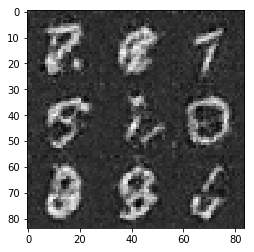

Step: 3110: Epoch 2/2... Discriminator Loss: 0.1484... Generator Loss: 2.7258
Step: 3120: Epoch 2/2... Discriminator Loss: 6.9910... Generator Loss: 8.8024
Step: 3130: Epoch 2/2... Discriminator Loss: 1.3775... Generator Loss: 0.4563
Step: 3140: Epoch 2/2... Discriminator Loss: 0.8811... Generator Loss: 0.8622
Step: 3150: Epoch 2/2... Discriminator Loss: 0.5677... Generator Loss: 1.4146
Step: 3160: Epoch 2/2... Discriminator Loss: 0.6125... Generator Loss: 1.0918
Step: 3170: Epoch 2/2... Discriminator Loss: 0.4992... Generator Loss: 1.2213
Step: 3180: Epoch 2/2... Discriminator Loss: 0.3873... Generator Loss: 3.5741
Step: 3190: Epoch 2/2... Discriminator Loss: 2.4328... Generator Loss: 7.1925
Step: 3200: Epoch 2/2... Discriminator Loss: 0.2540... Generator Loss: 2.2159


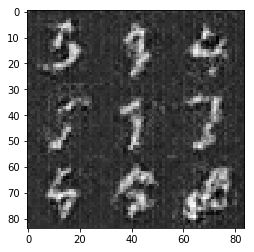

Step: 3210: Epoch 2/2... Discriminator Loss: 0.3291... Generator Loss: 2.8225
Step: 3220: Epoch 2/2... Discriminator Loss: 0.3523... Generator Loss: 1.6024
Step: 3230: Epoch 2/2... Discriminator Loss: 1.6064... Generator Loss: 6.4223
Step: 3240: Epoch 2/2... Discriminator Loss: 0.1840... Generator Loss: 2.5796
Step: 3250: Epoch 2/2... Discriminator Loss: 0.2006... Generator Loss: 2.2442
Step: 3260: Epoch 2/2... Discriminator Loss: 2.1964... Generator Loss: 7.7339
Step: 3270: Epoch 2/2... Discriminator Loss: 0.2343... Generator Loss: 2.2851
Step: 3280: Epoch 2/2... Discriminator Loss: 0.1106... Generator Loss: 3.1250
Step: 3290: Epoch 2/2... Discriminator Loss: 0.1645... Generator Loss: 3.7101
Step: 3300: Epoch 2/2... Discriminator Loss: 0.1656... Generator Loss: 2.5626


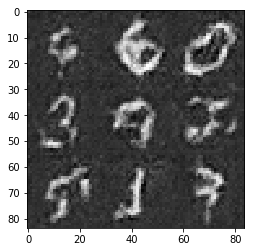

Step: 3310: Epoch 2/2... Discriminator Loss: 0.1258... Generator Loss: 2.8492
Step: 3320: Epoch 2/2... Discriminator Loss: 0.0860... Generator Loss: 3.2152
Step: 3330: Epoch 2/2... Discriminator Loss: 0.1484... Generator Loss: 2.4855
Step: 3340: Epoch 2/2... Discriminator Loss: 0.3856... Generator Loss: 1.4055
Step: 3350: Epoch 2/2... Discriminator Loss: 0.0974... Generator Loss: 2.9382
Step: 3360: Epoch 2/2... Discriminator Loss: 0.1258... Generator Loss: 2.6523
Step: 3370: Epoch 2/2... Discriminator Loss: 0.1581... Generator Loss: 2.5349
Step: 3380: Epoch 2/2... Discriminator Loss: 0.1102... Generator Loss: 2.7936
Step: 3390: Epoch 2/2... Discriminator Loss: 0.0793... Generator Loss: 3.7710
Step: 3400: Epoch 2/2... Discriminator Loss: 0.2267... Generator Loss: 2.3551


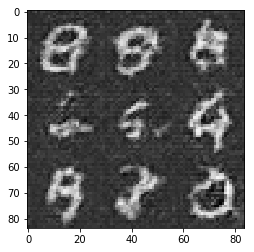

Step: 3410: Epoch 2/2... Discriminator Loss: 0.2080... Generator Loss: 2.3173
Step: 3420: Epoch 2/2... Discriminator Loss: 0.1594... Generator Loss: 2.6186
Step: 3430: Epoch 2/2... Discriminator Loss: 0.4325... Generator Loss: 1.2335
Step: 3440: Epoch 2/2... Discriminator Loss: 0.1493... Generator Loss: 2.5302
Step: 3450: Epoch 2/2... Discriminator Loss: 0.1704... Generator Loss: 2.2231
Step: 3460: Epoch 2/2... Discriminator Loss: 0.2108... Generator Loss: 2.1517
Step: 3470: Epoch 2/2... Discriminator Loss: 0.1539... Generator Loss: 2.3214
Step: 3480: Epoch 2/2... Discriminator Loss: 0.2208... Generator Loss: 1.9825
Step: 3490: Epoch 2/2... Discriminator Loss: 0.1816... Generator Loss: 2.1907
Step: 3500: Epoch 2/2... Discriminator Loss: 0.1884... Generator Loss: 2.0962


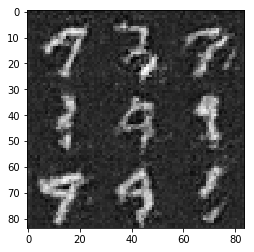

Step: 3510: Epoch 2/2... Discriminator Loss: 0.2461... Generator Loss: 1.9883
Step: 3520: Epoch 2/2... Discriminator Loss: 0.2502... Generator Loss: 1.8337
Step: 3530: Epoch 2/2... Discriminator Loss: 0.1434... Generator Loss: 2.3988
Step: 3540: Epoch 2/2... Discriminator Loss: 0.3574... Generator Loss: 1.5137
Step: 3550: Epoch 2/2... Discriminator Loss: 0.2137... Generator Loss: 2.0910
Step: 3560: Epoch 2/2... Discriminator Loss: 1.1914... Generator Loss: 0.5651
Step: 3570: Epoch 2/2... Discriminator Loss: 0.3008... Generator Loss: 1.6504
Step: 3580: Epoch 2/2... Discriminator Loss: 0.1533... Generator Loss: 2.3907
Step: 3590: Epoch 2/2... Discriminator Loss: 0.2281... Generator Loss: 2.1809
Step: 3600: Epoch 2/2... Discriminator Loss: 0.2136... Generator Loss: 2.1788


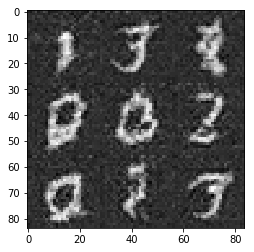

Step: 3610: Epoch 2/2... Discriminator Loss: 0.2772... Generator Loss: 2.1923
Step: 3620: Epoch 2/2... Discriminator Loss: 0.2499... Generator Loss: 1.8402
Step: 3630: Epoch 2/2... Discriminator Loss: 0.1322... Generator Loss: 2.5957
Step: 3640: Epoch 2/2... Discriminator Loss: 0.1759... Generator Loss: 2.3512
Step: 3650: Epoch 2/2... Discriminator Loss: 0.3069... Generator Loss: 1.7677
Step: 3660: Epoch 2/2... Discriminator Loss: 0.0903... Generator Loss: 3.0501
Step: 3670: Epoch 2/2... Discriminator Loss: 0.4098... Generator Loss: 1.3975
Step: 3680: Epoch 2/2... Discriminator Loss: 0.4517... Generator Loss: 1.5303
Step: 3690: Epoch 2/2... Discriminator Loss: 0.2132... Generator Loss: 2.1762
Step: 3700: Epoch 2/2... Discriminator Loss: 0.2689... Generator Loss: 2.0671


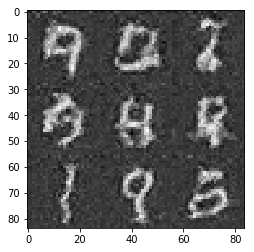

Step: 3710: Epoch 2/2... Discriminator Loss: 0.2170... Generator Loss: 2.2619
Step: 3720: Epoch 2/2... Discriminator Loss: 0.2533... Generator Loss: 2.0397
Step: 3730: Epoch 2/2... Discriminator Loss: 0.1574... Generator Loss: 2.5231
Step: 3740: Epoch 2/2... Discriminator Loss: 0.2023... Generator Loss: 2.3312
Step: 3750: Epoch 2/2... Discriminator Loss: 0.2473... Generator Loss: 1.9727


In [29]:
batch_size = 32
z_dim = 200
learning_rate = 0.0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Step: 10: Epoch 1/1... Discriminator Loss: 0.3213... Generator Loss: 1.5374
Step: 20: Epoch 1/1... Discriminator Loss: 0.2333... Generator Loss: 1.9161
Step: 30: Epoch 1/1... Discriminator Loss: 0.1057... Generator Loss: 2.7945
Step: 40: Epoch 1/1... Discriminator Loss: 0.3806... Generator Loss: 1.6132
Step: 50: Epoch 1/1... Discriminator Loss: 0.1739... Generator Loss: 2.2043
Step: 60: Epoch 1/1... Discriminator Loss: 0.0843... Generator Loss: 5.3573
Step: 70: Epoch 1/1... Discriminator Loss: 1.1197... Generator Loss: 0.6527
Step: 80: Epoch 1/1... Discriminator Loss: 0.5112... Generator Loss: 1.3794
Step: 90: Epoch 1/1... Discriminator Loss: 0.6130... Generator Loss: 1.1265
Step: 100: Epoch 1/1... Discriminator Loss: 0.1762... Generator Loss: 2.3205


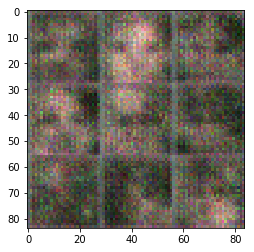

Step: 110: Epoch 1/1... Discriminator Loss: 0.1839... Generator Loss: 2.9939
Step: 120: Epoch 1/1... Discriminator Loss: 0.1536... Generator Loss: 2.9955
Step: 130: Epoch 1/1... Discriminator Loss: 0.2285... Generator Loss: 2.2786
Step: 140: Epoch 1/1... Discriminator Loss: 0.1870... Generator Loss: 2.3232
Step: 150: Epoch 1/1... Discriminator Loss: 0.1896... Generator Loss: 2.4311
Step: 160: Epoch 1/1... Discriminator Loss: 0.1593... Generator Loss: 2.3377
Step: 170: Epoch 1/1... Discriminator Loss: 0.2006... Generator Loss: 2.4064
Step: 180: Epoch 1/1... Discriminator Loss: 2.0902... Generator Loss: 0.2957
Step: 190: Epoch 1/1... Discriminator Loss: 0.1114... Generator Loss: 2.7192
Step: 200: Epoch 1/1... Discriminator Loss: 0.1679... Generator Loss: 2.2912


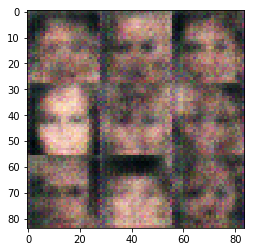

Step: 210: Epoch 1/1... Discriminator Loss: 0.0909... Generator Loss: 3.1355
Step: 220: Epoch 1/1... Discriminator Loss: 0.1904... Generator Loss: 2.1684
Step: 230: Epoch 1/1... Discriminator Loss: 0.0955... Generator Loss: 3.2709
Step: 240: Epoch 1/1... Discriminator Loss: 5.9182... Generator Loss: 12.6115
Step: 250: Epoch 1/1... Discriminator Loss: 2.9710... Generator Loss: 9.8739
Step: 260: Epoch 1/1... Discriminator Loss: 0.2465... Generator Loss: 2.3287
Step: 270: Epoch 1/1... Discriminator Loss: 0.1058... Generator Loss: 2.9727
Step: 280: Epoch 1/1... Discriminator Loss: 0.3086... Generator Loss: 3.9978
Step: 290: Epoch 1/1... Discriminator Loss: 0.1146... Generator Loss: 2.8777
Step: 300: Epoch 1/1... Discriminator Loss: 0.3740... Generator Loss: 1.6076


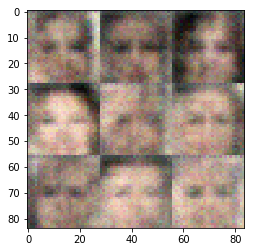

Step: 310: Epoch 1/1... Discriminator Loss: 0.7326... Generator Loss: 0.9353
Step: 320: Epoch 1/1... Discriminator Loss: 0.5862... Generator Loss: 2.0681
Step: 330: Epoch 1/1... Discriminator Loss: 0.2470... Generator Loss: 1.8420
Step: 340: Epoch 1/1... Discriminator Loss: 0.1279... Generator Loss: 2.7194
Step: 350: Epoch 1/1... Discriminator Loss: 0.2798... Generator Loss: 2.6352
Step: 360: Epoch 1/1... Discriminator Loss: 0.2894... Generator Loss: 1.8735
Step: 370: Epoch 1/1... Discriminator Loss: 0.2003... Generator Loss: 2.4227
Step: 380: Epoch 1/1... Discriminator Loss: 2.3109... Generator Loss: 0.1542
Step: 390: Epoch 1/1... Discriminator Loss: 0.1740... Generator Loss: 2.4386
Step: 400: Epoch 1/1... Discriminator Loss: 2.6681... Generator Loss: 8.1652


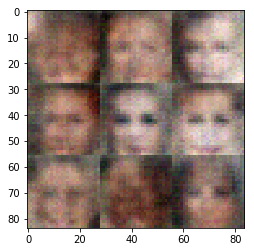

Step: 410: Epoch 1/1... Discriminator Loss: 0.4622... Generator Loss: 1.5492
Step: 420: Epoch 1/1... Discriminator Loss: 0.4878... Generator Loss: 1.3435
Step: 430: Epoch 1/1... Discriminator Loss: 0.1652... Generator Loss: 2.9777
Step: 440: Epoch 1/1... Discriminator Loss: 0.0821... Generator Loss: 3.4012
Step: 450: Epoch 1/1... Discriminator Loss: 0.1344... Generator Loss: 2.7366
Step: 460: Epoch 1/1... Discriminator Loss: 0.3245... Generator Loss: 1.5718
Step: 470: Epoch 1/1... Discriminator Loss: 2.0711... Generator Loss: 0.1966
Step: 480: Epoch 1/1... Discriminator Loss: 0.3564... Generator Loss: 1.7208
Step: 490: Epoch 1/1... Discriminator Loss: 0.6219... Generator Loss: 0.9631
Step: 500: Epoch 1/1... Discriminator Loss: 0.2548... Generator Loss: 2.1102


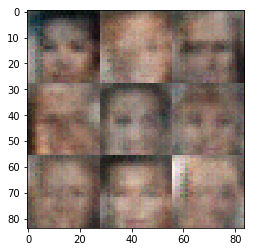

Step: 510: Epoch 1/1... Discriminator Loss: 0.2176... Generator Loss: 2.2905
Step: 520: Epoch 1/1... Discriminator Loss: 0.5911... Generator Loss: 1.0772
Step: 530: Epoch 1/1... Discriminator Loss: 0.2403... Generator Loss: 1.8851
Step: 540: Epoch 1/1... Discriminator Loss: 1.4712... Generator Loss: 0.3819
Step: 550: Epoch 1/1... Discriminator Loss: 0.3979... Generator Loss: 1.5582
Step: 560: Epoch 1/1... Discriminator Loss: 0.3279... Generator Loss: 1.6364
Step: 570: Epoch 1/1... Discriminator Loss: 1.0903... Generator Loss: 0.5201
Step: 580: Epoch 1/1... Discriminator Loss: 0.0575... Generator Loss: 3.4408
Step: 590: Epoch 1/1... Discriminator Loss: 0.1336... Generator Loss: 2.6780
Step: 600: Epoch 1/1... Discriminator Loss: 0.3940... Generator Loss: 4.3869


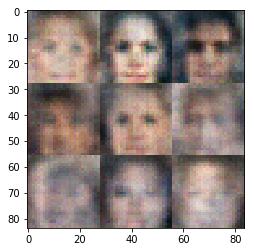

Step: 610: Epoch 1/1... Discriminator Loss: 0.5248... Generator Loss: 1.2426
Step: 620: Epoch 1/1... Discriminator Loss: 0.3244... Generator Loss: 1.6989
Step: 630: Epoch 1/1... Discriminator Loss: 0.1545... Generator Loss: 2.4303
Step: 640: Epoch 1/1... Discriminator Loss: 0.1422... Generator Loss: 2.5377
Step: 650: Epoch 1/1... Discriminator Loss: 1.3254... Generator Loss: 0.4523
Step: 660: Epoch 1/1... Discriminator Loss: 0.4196... Generator Loss: 1.4810
Step: 670: Epoch 1/1... Discriminator Loss: 0.5082... Generator Loss: 1.3456
Step: 680: Epoch 1/1... Discriminator Loss: 0.2927... Generator Loss: 1.9412
Step: 690: Epoch 1/1... Discriminator Loss: 0.2580... Generator Loss: 2.1267
Step: 700: Epoch 1/1... Discriminator Loss: 0.3477... Generator Loss: 1.7840


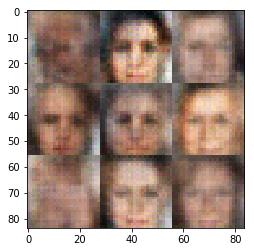

Step: 710: Epoch 1/1... Discriminator Loss: 0.1466... Generator Loss: 2.5701
Step: 720: Epoch 1/1... Discriminator Loss: 0.4947... Generator Loss: 1.1666
Step: 730: Epoch 1/1... Discriminator Loss: 0.1346... Generator Loss: 2.7615
Step: 740: Epoch 1/1... Discriminator Loss: 0.6414... Generator Loss: 2.0770
Step: 750: Epoch 1/1... Discriminator Loss: 0.2597... Generator Loss: 2.3728
Step: 760: Epoch 1/1... Discriminator Loss: 0.6137... Generator Loss: 1.1840
Step: 770: Epoch 1/1... Discriminator Loss: 0.3472... Generator Loss: 1.6329
Step: 780: Epoch 1/1... Discriminator Loss: 0.4608... Generator Loss: 1.3133
Step: 790: Epoch 1/1... Discriminator Loss: 0.2642... Generator Loss: 3.2772
Step: 800: Epoch 1/1... Discriminator Loss: 0.1866... Generator Loss: 3.1210


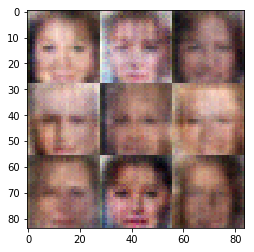

Step: 810: Epoch 1/1... Discriminator Loss: 0.2669... Generator Loss: 2.0936
Step: 820: Epoch 1/1... Discriminator Loss: 0.1838... Generator Loss: 2.2786
Step: 830: Epoch 1/1... Discriminator Loss: 0.1913... Generator Loss: 2.2084
Step: 840: Epoch 1/1... Discriminator Loss: 0.1100... Generator Loss: 3.1392
Step: 850: Epoch 1/1... Discriminator Loss: 0.0978... Generator Loss: 2.9772
Step: 860: Epoch 1/1... Discriminator Loss: 0.1541... Generator Loss: 2.3597
Step: 870: Epoch 1/1... Discriminator Loss: 0.0725... Generator Loss: 3.8315
Step: 880: Epoch 1/1... Discriminator Loss: 0.0835... Generator Loss: 3.3745
Step: 890: Epoch 1/1... Discriminator Loss: 3.1287... Generator Loss: 0.0753
Step: 900: Epoch 1/1... Discriminator Loss: 1.0745... Generator Loss: 0.6290


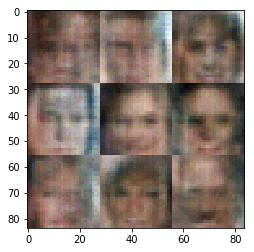

Step: 910: Epoch 1/1... Discriminator Loss: 0.4593... Generator Loss: 1.4335
Step: 920: Epoch 1/1... Discriminator Loss: 0.3380... Generator Loss: 1.5428
Step: 930: Epoch 1/1... Discriminator Loss: 0.7484... Generator Loss: 0.8694
Step: 940: Epoch 1/1... Discriminator Loss: 0.2726... Generator Loss: 2.0468
Step: 950: Epoch 1/1... Discriminator Loss: 0.1519... Generator Loss: 3.4824
Step: 960: Epoch 1/1... Discriminator Loss: 0.2165... Generator Loss: 2.0995
Step: 970: Epoch 1/1... Discriminator Loss: 0.2071... Generator Loss: 5.7678
Step: 980: Epoch 1/1... Discriminator Loss: 0.0478... Generator Loss: 4.9520
Step: 990: Epoch 1/1... Discriminator Loss: 0.0889... Generator Loss: 3.9385
Step: 1000: Epoch 1/1... Discriminator Loss: 1.1149... Generator Loss: 5.2839


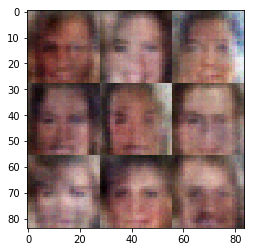

Step: 1010: Epoch 1/1... Discriminator Loss: 0.2097... Generator Loss: 2.4433
Step: 1020: Epoch 1/1... Discriminator Loss: 0.1250... Generator Loss: 2.8210
Step: 1030: Epoch 1/1... Discriminator Loss: 0.6540... Generator Loss: 4.9463
Step: 1040: Epoch 1/1... Discriminator Loss: 0.1136... Generator Loss: 3.0992
Step: 1050: Epoch 1/1... Discriminator Loss: 0.0852... Generator Loss: 3.5364
Step: 1060: Epoch 1/1... Discriminator Loss: 0.7978... Generator Loss: 5.7080
Step: 1070: Epoch 1/1... Discriminator Loss: 0.2307... Generator Loss: 2.1830
Step: 1080: Epoch 1/1... Discriminator Loss: 0.1819... Generator Loss: 2.1667
Step: 1090: Epoch 1/1... Discriminator Loss: 1.3861... Generator Loss: 0.4486
Step: 1100: Epoch 1/1... Discriminator Loss: 0.4047... Generator Loss: 1.9178


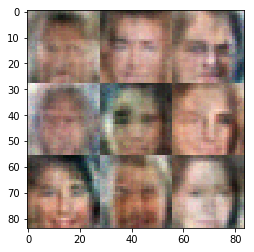

Step: 1110: Epoch 1/1... Discriminator Loss: 0.6879... Generator Loss: 0.8422
Step: 1120: Epoch 1/1... Discriminator Loss: 0.1794... Generator Loss: 2.3031
Step: 1130: Epoch 1/1... Discriminator Loss: 0.4107... Generator Loss: 1.4599
Step: 1140: Epoch 1/1... Discriminator Loss: 0.1390... Generator Loss: 2.6631
Step: 1150: Epoch 1/1... Discriminator Loss: 0.0686... Generator Loss: 4.3661
Step: 1160: Epoch 1/1... Discriminator Loss: 0.4378... Generator Loss: 5.1206
Step: 1170: Epoch 1/1... Discriminator Loss: 0.0563... Generator Loss: 4.1445
Step: 1180: Epoch 1/1... Discriminator Loss: 1.2203... Generator Loss: 0.5582
Step: 1190: Epoch 1/1... Discriminator Loss: 0.0341... Generator Loss: 4.8103
Step: 1200: Epoch 1/1... Discriminator Loss: 0.5443... Generator Loss: 1.2621


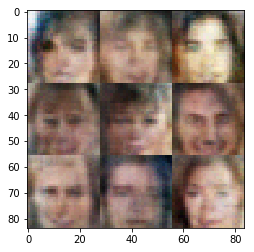

Step: 1210: Epoch 1/1... Discriminator Loss: 0.3254... Generator Loss: 1.6998
Step: 1220: Epoch 1/1... Discriminator Loss: 0.1684... Generator Loss: 2.3024
Step: 1230: Epoch 1/1... Discriminator Loss: 0.3594... Generator Loss: 1.5405
Step: 1240: Epoch 1/1... Discriminator Loss: 0.4489... Generator Loss: 1.4744
Step: 1250: Epoch 1/1... Discriminator Loss: 0.9266... Generator Loss: 0.7191
Step: 1260: Epoch 1/1... Discriminator Loss: 0.6136... Generator Loss: 1.2201
Step: 1270: Epoch 1/1... Discriminator Loss: 0.0537... Generator Loss: 4.8966
Step: 1280: Epoch 1/1... Discriminator Loss: 0.1538... Generator Loss: 2.8254
Step: 1290: Epoch 1/1... Discriminator Loss: 0.0582... Generator Loss: 3.5267
Step: 1300: Epoch 1/1... Discriminator Loss: 0.0616... Generator Loss: 4.1271


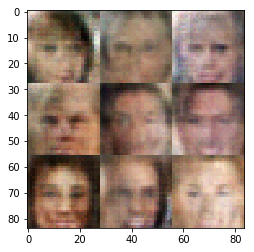

Step: 1310: Epoch 1/1... Discriminator Loss: 0.0330... Generator Loss: 4.8790
Step: 1320: Epoch 1/1... Discriminator Loss: 0.0429... Generator Loss: 7.0905
Step: 1330: Epoch 1/1... Discriminator Loss: 0.1237... Generator Loss: 3.9291
Step: 1340: Epoch 1/1... Discriminator Loss: 0.0333... Generator Loss: 5.0566
Step: 1350: Epoch 1/1... Discriminator Loss: 0.1725... Generator Loss: 4.2468
Step: 1360: Epoch 1/1... Discriminator Loss: 0.1289... Generator Loss: 2.5542
Step: 1370: Epoch 1/1... Discriminator Loss: 0.0316... Generator Loss: 6.2960
Step: 1380: Epoch 1/1... Discriminator Loss: 1.1062... Generator Loss: 0.6998
Step: 1390: Epoch 1/1... Discriminator Loss: 0.0435... Generator Loss: 5.0119
Step: 1400: Epoch 1/1... Discriminator Loss: 0.0424... Generator Loss: 4.2281


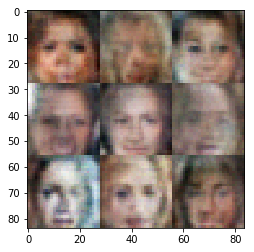

Step: 1410: Epoch 1/1... Discriminator Loss: 0.0816... Generator Loss: 9.0091
Step: 1420: Epoch 1/1... Discriminator Loss: 0.0357... Generator Loss: 3.9110
Step: 1430: Epoch 1/1... Discriminator Loss: 0.0064... Generator Loss: 5.7821
Step: 1440: Epoch 1/1... Discriminator Loss: 0.0418... Generator Loss: 4.0942
Step: 1450: Epoch 1/1... Discriminator Loss: 0.0687... Generator Loss: 3.1726
Step: 1460: Epoch 1/1... Discriminator Loss: 0.0391... Generator Loss: 7.0897
Step: 1470: Epoch 1/1... Discriminator Loss: 1.2861... Generator Loss: 0.5848
Step: 1480: Epoch 1/1... Discriminator Loss: 0.0439... Generator Loss: 7.9834
Step: 1490: Epoch 1/1... Discriminator Loss: 0.3942... Generator Loss: 1.5074
Step: 1500: Epoch 1/1... Discriminator Loss: 0.0323... Generator Loss: 4.6238


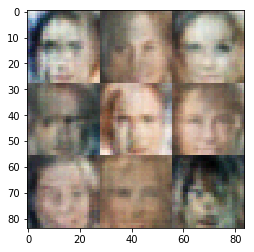

Step: 1510: Epoch 1/1... Discriminator Loss: 0.1281... Generator Loss: 2.6143
Step: 1520: Epoch 1/1... Discriminator Loss: 0.0304... Generator Loss: 8.0064
Step: 1530: Epoch 1/1... Discriminator Loss: 1.1625... Generator Loss: 0.5199
Step: 1540: Epoch 1/1... Discriminator Loss: 1.6920... Generator Loss: 0.3290
Step: 1550: Epoch 1/1... Discriminator Loss: 0.0284... Generator Loss: 5.9664
Step: 1560: Epoch 1/1... Discriminator Loss: 0.0117... Generator Loss: 7.1638
Step: 1570: Epoch 1/1... Discriminator Loss: 0.0113... Generator Loss: 10.6462
Step: 1580: Epoch 1/1... Discriminator Loss: 0.0165... Generator Loss: 5.7541
Step: 1590: Epoch 1/1... Discriminator Loss: 0.0161... Generator Loss: 9.3110
Step: 1600: Epoch 1/1... Discriminator Loss: 0.0195... Generator Loss: 11.0474


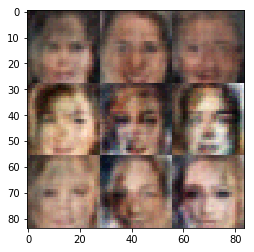

Step: 1610: Epoch 1/1... Discriminator Loss: 0.0054... Generator Loss: 9.3728
Step: 1620: Epoch 1/1... Discriminator Loss: 3.3189... Generator Loss: 0.0673
Step: 1630: Epoch 1/1... Discriminator Loss: 0.2650... Generator Loss: 3.6892
Step: 1640: Epoch 1/1... Discriminator Loss: 0.0995... Generator Loss: 4.2905
Step: 1650: Epoch 1/1... Discriminator Loss: 0.5088... Generator Loss: 7.9494
Step: 1660: Epoch 1/1... Discriminator Loss: 0.1287... Generator Loss: 2.7856
Step: 1670: Epoch 1/1... Discriminator Loss: 0.1956... Generator Loss: 2.3447
Step: 1680: Epoch 1/1... Discriminator Loss: 0.9746... Generator Loss: 0.7081
Step: 1690: Epoch 1/1... Discriminator Loss: 0.0138... Generator Loss: 7.3561
Step: 1700: Epoch 1/1... Discriminator Loss: 0.0474... Generator Loss: 3.4541


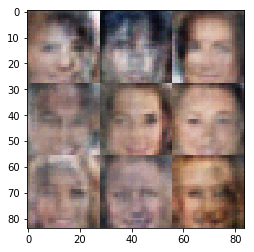

Step: 1710: Epoch 1/1... Discriminator Loss: 0.1361... Generator Loss: 2.7091
Step: 1720: Epoch 1/1... Discriminator Loss: 0.0235... Generator Loss: 7.1059
Step: 1730: Epoch 1/1... Discriminator Loss: 0.0166... Generator Loss: 5.7950
Step: 1740: Epoch 1/1... Discriminator Loss: 0.0783... Generator Loss: 3.9913
Step: 1750: Epoch 1/1... Discriminator Loss: 0.0488... Generator Loss: 6.8742
Step: 1760: Epoch 1/1... Discriminator Loss: 0.0380... Generator Loss: 8.6381
Step: 1770: Epoch 1/1... Discriminator Loss: 0.0272... Generator Loss: 4.8095
Step: 1780: Epoch 1/1... Discriminator Loss: 0.1570... Generator Loss: 4.6459
Step: 1790: Epoch 1/1... Discriminator Loss: 0.0060... Generator Loss: 6.3590
Step: 1800: Epoch 1/1... Discriminator Loss: 0.0167... Generator Loss: 9.1919


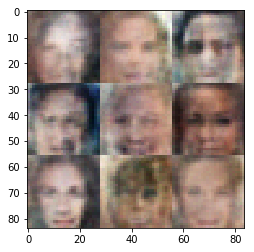

Step: 1810: Epoch 1/1... Discriminator Loss: 0.0082... Generator Loss: 10.2022
Step: 1820: Epoch 1/1... Discriminator Loss: 0.5015... Generator Loss: 1.3083
Step: 1830: Epoch 1/1... Discriminator Loss: 0.0128... Generator Loss: 10.8415
Step: 1840: Epoch 1/1... Discriminator Loss: 0.0554... Generator Loss: 12.1869
Step: 1850: Epoch 1/1... Discriminator Loss: 0.4487... Generator Loss: 1.2731
Step: 1860: Epoch 1/1... Discriminator Loss: 0.0554... Generator Loss: 8.0293
Step: 1870: Epoch 1/1... Discriminator Loss: 0.3623... Generator Loss: 1.4743
Step: 1880: Epoch 1/1... Discriminator Loss: 0.0154... Generator Loss: 4.8539
Step: 1890: Epoch 1/1... Discriminator Loss: 0.2286... Generator Loss: 2.0334
Step: 1900: Epoch 1/1... Discriminator Loss: 0.3476... Generator Loss: 1.5117


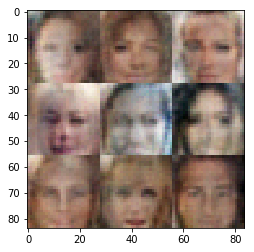

Step: 1910: Epoch 1/1... Discriminator Loss: 0.1450... Generator Loss: 3.1861
Step: 1920: Epoch 1/1... Discriminator Loss: 0.1022... Generator Loss: 6.7463
Step: 1930: Epoch 1/1... Discriminator Loss: 0.1345... Generator Loss: 3.0401
Step: 1940: Epoch 1/1... Discriminator Loss: 0.0429... Generator Loss: 9.4001
Step: 1950: Epoch 1/1... Discriminator Loss: 0.2119... Generator Loss: 2.0491
Step: 1960: Epoch 1/1... Discriminator Loss: 0.6987... Generator Loss: 0.9919
Step: 1970: Epoch 1/1... Discriminator Loss: 0.6999... Generator Loss: 0.9764
Step: 1980: Epoch 1/1... Discriminator Loss: 0.0349... Generator Loss: 4.2735
Step: 1990: Epoch 1/1... Discriminator Loss: 0.0507... Generator Loss: 5.5596
Step: 2000: Epoch 1/1... Discriminator Loss: 0.0071... Generator Loss: 5.5507


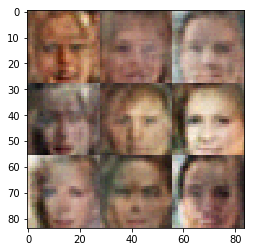

Step: 2010: Epoch 1/1... Discriminator Loss: 0.0055... Generator Loss: 8.3500
Step: 2020: Epoch 1/1... Discriminator Loss: 0.0160... Generator Loss: 4.6949
Step: 2030: Epoch 1/1... Discriminator Loss: 0.2051... Generator Loss: 3.0851
Step: 2040: Epoch 1/1... Discriminator Loss: 0.0143... Generator Loss: 8.6066
Step: 2050: Epoch 1/1... Discriminator Loss: 0.1256... Generator Loss: 5.6033
Step: 2060: Epoch 1/1... Discriminator Loss: 0.6914... Generator Loss: 0.9545
Step: 2070: Epoch 1/1... Discriminator Loss: 0.0140... Generator Loss: 6.3535
Step: 2080: Epoch 1/1... Discriminator Loss: 0.0113... Generator Loss: 5.6388
Step: 2090: Epoch 1/1... Discriminator Loss: 0.0197... Generator Loss: 14.2060
Step: 2100: Epoch 1/1... Discriminator Loss: 0.0441... Generator Loss: 10.8839


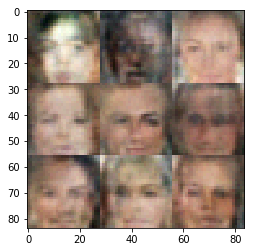

Step: 2110: Epoch 1/1... Discriminator Loss: 0.0236... Generator Loss: 7.3327
Step: 2120: Epoch 1/1... Discriminator Loss: 0.0085... Generator Loss: 12.6025
Step: 2130: Epoch 1/1... Discriminator Loss: 0.0601... Generator Loss: 3.5362
Step: 2140: Epoch 1/1... Discriminator Loss: 0.0043... Generator Loss: 10.1438
Step: 2150: Epoch 1/1... Discriminator Loss: 0.0067... Generator Loss: 10.3762
Step: 2160: Epoch 1/1... Discriminator Loss: 0.0271... Generator Loss: 4.3492
Step: 2170: Epoch 1/1... Discriminator Loss: 0.0019... Generator Loss: 11.7577
Step: 2180: Epoch 1/1... Discriminator Loss: 0.0147... Generator Loss: 11.7296
Step: 2190: Epoch 1/1... Discriminator Loss: 0.0098... Generator Loss: 13.8086
Step: 2200: Epoch 1/1... Discriminator Loss: 0.0373... Generator Loss: 3.8748


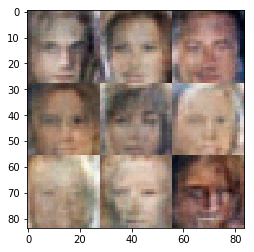

Step: 2210: Epoch 1/1... Discriminator Loss: 0.0120... Generator Loss: 9.1798
Step: 2220: Epoch 1/1... Discriminator Loss: 0.0198... Generator Loss: 14.8605
Step: 2230: Epoch 1/1... Discriminator Loss: 0.1750... Generator Loss: 2.2912
Step: 2240: Epoch 1/1... Discriminator Loss: 0.0052... Generator Loss: 7.5365
Step: 2250: Epoch 1/1... Discriminator Loss: 0.0075... Generator Loss: 15.4111
Step: 2260: Epoch 1/1... Discriminator Loss: 0.0576... Generator Loss: 3.3262
Step: 2270: Epoch 1/1... Discriminator Loss: 0.0089... Generator Loss: 13.7896
Step: 2280: Epoch 1/1... Discriminator Loss: 0.0068... Generator Loss: 10.0876
Step: 2290: Epoch 1/1... Discriminator Loss: 0.4650... Generator Loss: 1.2849
Step: 2300: Epoch 1/1... Discriminator Loss: 4.3972... Generator Loss: 0.0270


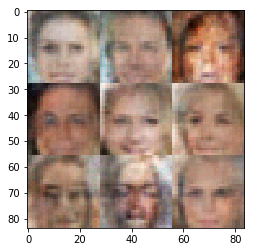

Step: 2310: Epoch 1/1... Discriminator Loss: 0.0576... Generator Loss: 5.1772
Step: 2320: Epoch 1/1... Discriminator Loss: 0.0570... Generator Loss: 4.2581
Step: 2330: Epoch 1/1... Discriminator Loss: 0.0279... Generator Loss: 7.2630
Step: 2340: Epoch 1/1... Discriminator Loss: 0.0683... Generator Loss: 4.2290
Step: 2350: Epoch 1/1... Discriminator Loss: 0.0332... Generator Loss: 8.1844
Step: 2360: Epoch 1/1... Discriminator Loss: 0.0378... Generator Loss: 8.4207
Step: 2370: Epoch 1/1... Discriminator Loss: 0.0100... Generator Loss: 8.2027
Step: 2380: Epoch 1/1... Discriminator Loss: 1.3246... Generator Loss: 0.3918
Step: 2390: Epoch 1/1... Discriminator Loss: 0.1052... Generator Loss: 2.7563
Step: 2400: Epoch 1/1... Discriminator Loss: 0.0339... Generator Loss: 4.1227


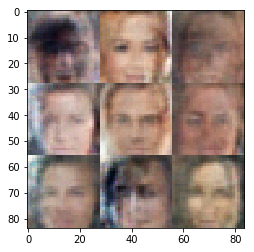

Step: 2410: Epoch 1/1... Discriminator Loss: 0.0169... Generator Loss: 12.4937
Step: 2420: Epoch 1/1... Discriminator Loss: 0.0154... Generator Loss: 8.2108
Step: 2430: Epoch 1/1... Discriminator Loss: 2.5853... Generator Loss: 6.8758
Step: 2440: Epoch 1/1... Discriminator Loss: 0.1655... Generator Loss: 2.5064
Step: 2450: Epoch 1/1... Discriminator Loss: 0.9168... Generator Loss: 0.7062
Step: 2460: Epoch 1/1... Discriminator Loss: 0.0317... Generator Loss: 6.6908
Step: 2470: Epoch 1/1... Discriminator Loss: 0.0290... Generator Loss: 9.2082
Step: 2480: Epoch 1/1... Discriminator Loss: 0.1071... Generator Loss: 2.6989
Step: 2490: Epoch 1/1... Discriminator Loss: 0.0100... Generator Loss: 7.8329
Step: 2500: Epoch 1/1... Discriminator Loss: 0.1324... Generator Loss: 2.8411


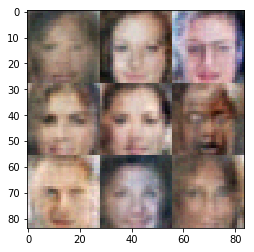

Step: 2510: Epoch 1/1... Discriminator Loss: 0.0954... Generator Loss: 2.8476
Step: 2520: Epoch 1/1... Discriminator Loss: 0.0070... Generator Loss: 10.2781
Step: 2530: Epoch 1/1... Discriminator Loss: 0.0143... Generator Loss: 10.2387
Step: 2540: Epoch 1/1... Discriminator Loss: 0.0206... Generator Loss: 4.4341
Step: 2550: Epoch 1/1... Discriminator Loss: 0.2603... Generator Loss: 1.8181
Step: 2560: Epoch 1/1... Discriminator Loss: 0.0405... Generator Loss: 9.6901
Step: 2570: Epoch 1/1... Discriminator Loss: 0.0041... Generator Loss: 12.9133
Step: 2580: Epoch 1/1... Discriminator Loss: 0.1737... Generator Loss: 2.3400
Step: 2590: Epoch 1/1... Discriminator Loss: 0.0172... Generator Loss: 7.1377
Step: 2600: Epoch 1/1... Discriminator Loss: 0.0998... Generator Loss: 2.8167


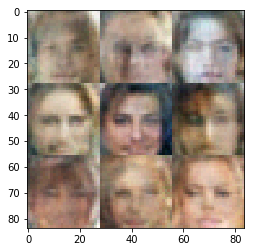

Step: 2610: Epoch 1/1... Discriminator Loss: 0.0068... Generator Loss: 6.7932
Step: 2620: Epoch 1/1... Discriminator Loss: 0.0167... Generator Loss: 5.3011
Step: 2630: Epoch 1/1... Discriminator Loss: 0.0817... Generator Loss: 3.0795
Step: 2640: Epoch 1/1... Discriminator Loss: 0.0061... Generator Loss: 10.4114
Step: 2650: Epoch 1/1... Discriminator Loss: 0.0053... Generator Loss: 8.5747
Step: 2660: Epoch 1/1... Discriminator Loss: 0.0076... Generator Loss: 11.7534
Step: 2670: Epoch 1/1... Discriminator Loss: 0.4727... Generator Loss: 1.2322
Step: 2680: Epoch 1/1... Discriminator Loss: 0.0060... Generator Loss: 11.2300
Step: 2690: Epoch 1/1... Discriminator Loss: 0.0139... Generator Loss: 11.8879
Step: 2700: Epoch 1/1... Discriminator Loss: 0.0264... Generator Loss: 7.7089


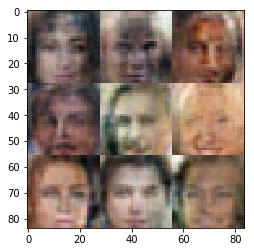

Step: 2710: Epoch 1/1... Discriminator Loss: 0.2353... Generator Loss: 1.9520
Step: 2720: Epoch 1/1... Discriminator Loss: 0.0444... Generator Loss: 11.8577
Step: 2730: Epoch 1/1... Discriminator Loss: 0.0483... Generator Loss: 3.6688
Step: 2740: Epoch 1/1... Discriminator Loss: 0.0128... Generator Loss: 12.1901
Step: 2750: Epoch 1/1... Discriminator Loss: 0.7477... Generator Loss: 0.8635
Step: 2760: Epoch 1/1... Discriminator Loss: 0.5183... Generator Loss: 1.1573
Step: 2770: Epoch 1/1... Discriminator Loss: 0.3164... Generator Loss: 1.7080
Step: 2780: Epoch 1/1... Discriminator Loss: 0.1016... Generator Loss: 9.0152
Step: 2790: Epoch 1/1... Discriminator Loss: 0.0064... Generator Loss: 6.8813
Step: 2800: Epoch 1/1... Discriminator Loss: 0.0574... Generator Loss: 4.0666


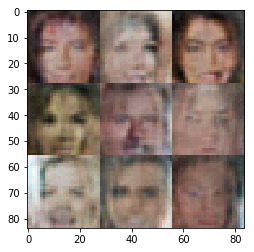

Step: 2810: Epoch 1/1... Discriminator Loss: 0.0244... Generator Loss: 7.2560
Step: 2820: Epoch 1/1... Discriminator Loss: 0.0067... Generator Loss: 8.8836
Step: 2830: Epoch 1/1... Discriminator Loss: 0.0163... Generator Loss: 7.7403
Step: 2840: Epoch 1/1... Discriminator Loss: 0.0115... Generator Loss: 8.8785
Step: 2850: Epoch 1/1... Discriminator Loss: 0.0623... Generator Loss: 3.9875
Step: 2860: Epoch 1/1... Discriminator Loss: 0.9557... Generator Loss: 0.7154
Step: 2870: Epoch 1/1... Discriminator Loss: 0.5292... Generator Loss: 4.9815
Step: 2880: Epoch 1/1... Discriminator Loss: 0.0685... Generator Loss: 3.8095
Step: 2890: Epoch 1/1... Discriminator Loss: 0.0196... Generator Loss: 5.9802
Step: 2900: Epoch 1/1... Discriminator Loss: 0.8144... Generator Loss: 8.7428


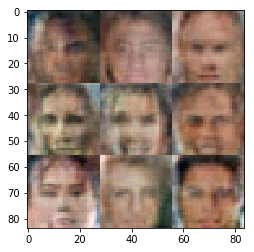

Step: 2910: Epoch 1/1... Discriminator Loss: 0.2147... Generator Loss: 2.0461
Step: 2920: Epoch 1/1... Discriminator Loss: 0.0535... Generator Loss: 11.6848
Step: 2930: Epoch 1/1... Discriminator Loss: 0.0245... Generator Loss: 4.8628
Step: 2940: Epoch 1/1... Discriminator Loss: 0.0418... Generator Loss: 5.7780
Step: 2950: Epoch 1/1... Discriminator Loss: 0.0924... Generator Loss: 3.1782
Step: 2960: Epoch 1/1... Discriminator Loss: 0.0263... Generator Loss: 10.1364
Step: 2970: Epoch 1/1... Discriminator Loss: 0.3648... Generator Loss: 1.5615
Step: 2980: Epoch 1/1... Discriminator Loss: 0.3159... Generator Loss: 1.5940
Step: 2990: Epoch 1/1... Discriminator Loss: 0.0407... Generator Loss: 3.5283
Step: 3000: Epoch 1/1... Discriminator Loss: 0.0053... Generator Loss: 8.6343


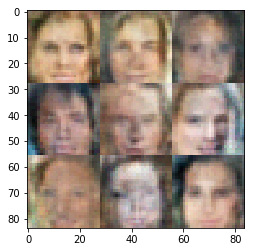

Step: 3010: Epoch 1/1... Discriminator Loss: 0.0742... Generator Loss: 3.3822
Step: 3020: Epoch 1/1... Discriminator Loss: 0.0025... Generator Loss: 8.8692
Step: 3030: Epoch 1/1... Discriminator Loss: 0.0310... Generator Loss: 7.3624
Step: 3040: Epoch 1/1... Discriminator Loss: 0.0301... Generator Loss: 13.8562
Step: 3050: Epoch 1/1... Discriminator Loss: 0.0042... Generator Loss: 11.2558
Step: 3060: Epoch 1/1... Discriminator Loss: 0.0155... Generator Loss: 13.8283
Step: 3070: Epoch 1/1... Discriminator Loss: 0.0296... Generator Loss: 14.0299
Step: 3080: Epoch 1/1... Discriminator Loss: 0.9076... Generator Loss: 0.6923
Step: 3090: Epoch 1/1... Discriminator Loss: 0.0372... Generator Loss: 10.0880
Step: 3100: Epoch 1/1... Discriminator Loss: 0.1252... Generator Loss: 2.7253


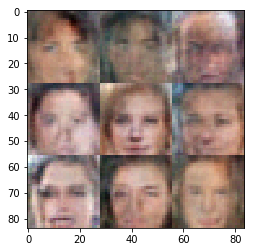

Step: 3110: Epoch 1/1... Discriminator Loss: 0.5584... Generator Loss: 1.2001
Step: 3120: Epoch 1/1... Discriminator Loss: 0.0229... Generator Loss: 5.7954
Step: 3130: Epoch 1/1... Discriminator Loss: 0.0067... Generator Loss: 6.2085
Step: 3140: Epoch 1/1... Discriminator Loss: 0.0127... Generator Loss: 7.8466
Step: 3150: Epoch 1/1... Discriminator Loss: 0.0122... Generator Loss: 13.5918
Step: 3160: Epoch 1/1... Discriminator Loss: 0.0331... Generator Loss: 7.0937
Step: 3170: Epoch 1/1... Discriminator Loss: 0.0658... Generator Loss: 3.7006
Step: 3180: Epoch 1/1... Discriminator Loss: 0.0571... Generator Loss: 4.0414
Step: 3190: Epoch 1/1... Discriminator Loss: 0.0173... Generator Loss: 9.6385
Step: 3200: Epoch 1/1... Discriminator Loss: 0.0194... Generator Loss: 7.0148


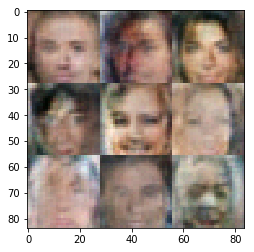

Step: 3210: Epoch 1/1... Discriminator Loss: 0.0041... Generator Loss: 6.1136
Step: 3220: Epoch 1/1... Discriminator Loss: 0.2054... Generator Loss: 2.0795
Step: 3230: Epoch 1/1... Discriminator Loss: 0.1636... Generator Loss: 2.2756
Step: 3240: Epoch 1/1... Discriminator Loss: 0.0153... Generator Loss: 7.9788
Step: 3250: Epoch 1/1... Discriminator Loss: 0.0051... Generator Loss: 10.2130
Step: 3260: Epoch 1/1... Discriminator Loss: 1.8565... Generator Loss: 5.4053
Step: 3270: Epoch 1/1... Discriminator Loss: 1.8445... Generator Loss: 7.7503
Step: 3280: Epoch 1/1... Discriminator Loss: 0.4759... Generator Loss: 1.4432
Step: 3290: Epoch 1/1... Discriminator Loss: 0.0923... Generator Loss: 3.2215
Step: 3300: Epoch 1/1... Discriminator Loss: 0.1640... Generator Loss: 2.4976


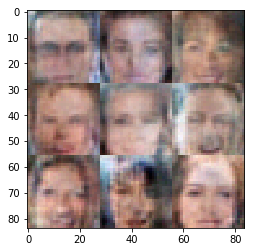

Step: 3310: Epoch 1/1... Discriminator Loss: 0.0560... Generator Loss: 3.7867
Step: 3320: Epoch 1/1... Discriminator Loss: 0.0060... Generator Loss: 7.4120
Step: 3330: Epoch 1/1... Discriminator Loss: 0.0124... Generator Loss: 8.6644
Step: 3340: Epoch 1/1... Discriminator Loss: 0.0298... Generator Loss: 4.1765
Step: 3350: Epoch 1/1... Discriminator Loss: 0.0129... Generator Loss: 4.7407
Step: 3360: Epoch 1/1... Discriminator Loss: 0.0737... Generator Loss: 4.4861
Step: 3370: Epoch 1/1... Discriminator Loss: 0.0384... Generator Loss: 4.3215
Step: 3380: Epoch 1/1... Discriminator Loss: 0.0188... Generator Loss: 5.5641
Step: 3390: Epoch 1/1... Discriminator Loss: 0.0215... Generator Loss: 7.3749
Step: 3400: Epoch 1/1... Discriminator Loss: 0.0348... Generator Loss: 5.9866


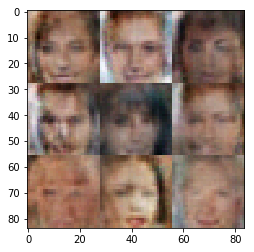

Step: 3410: Epoch 1/1... Discriminator Loss: 0.0092... Generator Loss: 8.5319
Step: 3420: Epoch 1/1... Discriminator Loss: 0.2194... Generator Loss: 5.4921
Step: 3430: Epoch 1/1... Discriminator Loss: 0.0399... Generator Loss: 3.9102
Step: 3440: Epoch 1/1... Discriminator Loss: 0.7217... Generator Loss: 0.9476
Step: 3450: Epoch 1/1... Discriminator Loss: 0.0710... Generator Loss: 3.1936
Step: 3460: Epoch 1/1... Discriminator Loss: 0.0260... Generator Loss: 8.0755
Step: 3470: Epoch 1/1... Discriminator Loss: 0.0409... Generator Loss: 3.6141
Step: 3480: Epoch 1/1... Discriminator Loss: 0.0340... Generator Loss: 4.0042
Step: 3490: Epoch 1/1... Discriminator Loss: 0.0157... Generator Loss: 10.2606
Step: 3500: Epoch 1/1... Discriminator Loss: 0.4544... Generator Loss: 1.3679


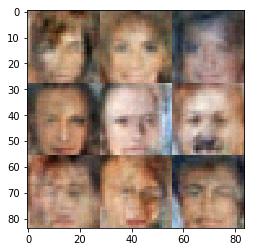

Step: 3510: Epoch 1/1... Discriminator Loss: 0.0058... Generator Loss: 8.0609
Step: 3520: Epoch 1/1... Discriminator Loss: 0.0092... Generator Loss: 5.7963
Step: 3530: Epoch 1/1... Discriminator Loss: 0.0079... Generator Loss: 6.2862
Step: 3540: Epoch 1/1... Discriminator Loss: 0.0151... Generator Loss: 8.6049
Step: 3550: Epoch 1/1... Discriminator Loss: 0.0079... Generator Loss: 6.9270
Step: 3560: Epoch 1/1... Discriminator Loss: 0.7739... Generator Loss: 0.8509
Step: 3570: Epoch 1/1... Discriminator Loss: 0.0450... Generator Loss: 5.0430
Step: 3580: Epoch 1/1... Discriminator Loss: 0.0321... Generator Loss: 5.7361
Step: 3590: Epoch 1/1... Discriminator Loss: 0.0448... Generator Loss: 3.9847
Step: 3600: Epoch 1/1... Discriminator Loss: 0.0140... Generator Loss: 5.8777


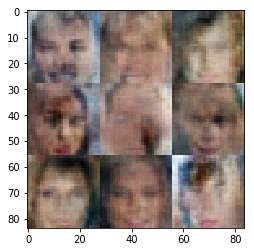

Step: 3610: Epoch 1/1... Discriminator Loss: 0.0241... Generator Loss: 5.6897
Step: 3620: Epoch 1/1... Discriminator Loss: 0.0167... Generator Loss: 9.0620
Step: 3630: Epoch 1/1... Discriminator Loss: 0.0155... Generator Loss: 7.5302
Step: 3640: Epoch 1/1... Discriminator Loss: 0.0078... Generator Loss: 13.1327
Step: 3650: Epoch 1/1... Discriminator Loss: 0.0269... Generator Loss: 12.2915
Step: 3660: Epoch 1/1... Discriminator Loss: 0.0154... Generator Loss: 13.1493
Step: 3670: Epoch 1/1... Discriminator Loss: 0.0330... Generator Loss: 7.0073
Step: 3680: Epoch 1/1... Discriminator Loss: 0.0756... Generator Loss: 3.5692
Step: 3690: Epoch 1/1... Discriminator Loss: 0.0091... Generator Loss: 10.5798
Step: 3700: Epoch 1/1... Discriminator Loss: 0.0536... Generator Loss: 3.3915


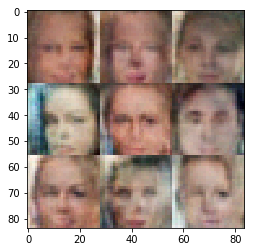

Step: 3710: Epoch 1/1... Discriminator Loss: 0.4737... Generator Loss: 10.9902
Step: 3720: Epoch 1/1... Discriminator Loss: 0.0525... Generator Loss: 3.7936
Step: 3730: Epoch 1/1... Discriminator Loss: 0.0154... Generator Loss: 12.7428
Step: 3740: Epoch 1/1... Discriminator Loss: 0.1185... Generator Loss: 2.6896
Step: 3750: Epoch 1/1... Discriminator Loss: 0.0104... Generator Loss: 5.8783
Step: 3760: Epoch 1/1... Discriminator Loss: 0.1374... Generator Loss: 2.5316
Step: 3770: Epoch 1/1... Discriminator Loss: 0.0103... Generator Loss: 5.1799
Step: 3780: Epoch 1/1... Discriminator Loss: 0.0044... Generator Loss: 11.7833
Step: 3790: Epoch 1/1... Discriminator Loss: 0.0047... Generator Loss: 8.1058
Step: 3800: Epoch 1/1... Discriminator Loss: 0.0166... Generator Loss: 8.2974


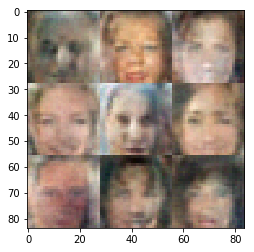

Step: 3810: Epoch 1/1... Discriminator Loss: 1.3288... Generator Loss: 0.5720
Step: 3820: Epoch 1/1... Discriminator Loss: 0.9581... Generator Loss: 0.6802
Step: 3830: Epoch 1/1... Discriminator Loss: 0.1437... Generator Loss: 2.6269
Step: 3840: Epoch 1/1... Discriminator Loss: 0.1057... Generator Loss: 3.1234
Step: 3850: Epoch 1/1... Discriminator Loss: 0.0086... Generator Loss: 8.3797
Step: 3860: Epoch 1/1... Discriminator Loss: 0.0081... Generator Loss: 9.6445
Step: 3870: Epoch 1/1... Discriminator Loss: 0.2593... Generator Loss: 1.9753
Step: 3880: Epoch 1/1... Discriminator Loss: 0.0231... Generator Loss: 11.4006
Step: 3890: Epoch 1/1... Discriminator Loss: 0.0685... Generator Loss: 3.5517
Step: 3900: Epoch 1/1... Discriminator Loss: 0.3807... Generator Loss: 1.4308


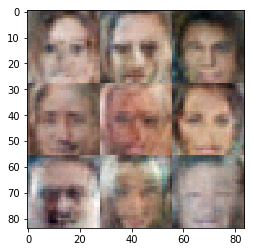

Step: 3910: Epoch 1/1... Discriminator Loss: 0.0297... Generator Loss: 4.9160
Step: 3920: Epoch 1/1... Discriminator Loss: 0.0080... Generator Loss: 8.3883
Step: 3930: Epoch 1/1... Discriminator Loss: 0.0203... Generator Loss: 7.8217
Step: 3940: Epoch 1/1... Discriminator Loss: 0.1188... Generator Loss: 2.5573
Step: 3950: Epoch 1/1... Discriminator Loss: 0.0136... Generator Loss: 8.8648
Step: 3960: Epoch 1/1... Discriminator Loss: 0.2306... Generator Loss: 1.8803
Step: 3970: Epoch 1/1... Discriminator Loss: 0.0366... Generator Loss: 7.4120
Step: 3980: Epoch 1/1... Discriminator Loss: 0.0206... Generator Loss: 14.9424
Step: 3990: Epoch 1/1... Discriminator Loss: 0.0171... Generator Loss: 13.7719
Step: 4000: Epoch 1/1... Discriminator Loss: 0.0085... Generator Loss: 10.7887


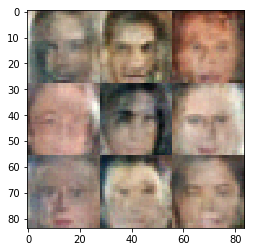

Step: 4010: Epoch 1/1... Discriminator Loss: 0.0135... Generator Loss: 6.8425
Step: 4020: Epoch 1/1... Discriminator Loss: 0.7385... Generator Loss: 2.2065
Step: 4030: Epoch 1/1... Discriminator Loss: 0.3544... Generator Loss: 1.5411
Step: 4040: Epoch 1/1... Discriminator Loss: 0.2500... Generator Loss: 1.9703
Step: 4050: Epoch 1/1... Discriminator Loss: 0.0277... Generator Loss: 4.7879
Step: 4060: Epoch 1/1... Discriminator Loss: 0.0134... Generator Loss: 5.3521
Step: 4070: Epoch 1/1... Discriminator Loss: 0.0064... Generator Loss: 9.8200
Step: 4080: Epoch 1/1... Discriminator Loss: 0.0154... Generator Loss: 9.7104
Step: 4090: Epoch 1/1... Discriminator Loss: 0.2988... Generator Loss: 1.8273
Step: 4100: Epoch 1/1... Discriminator Loss: 0.0623... Generator Loss: 3.4392


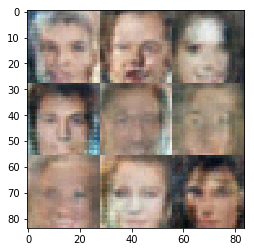

Step: 4110: Epoch 1/1... Discriminator Loss: 1.1442... Generator Loss: 5.9002
Step: 4120: Epoch 1/1... Discriminator Loss: 0.0195... Generator Loss: 5.4048
Step: 4130: Epoch 1/1... Discriminator Loss: 0.0338... Generator Loss: 9.1556
Step: 4140: Epoch 1/1... Discriminator Loss: 0.0200... Generator Loss: 6.5208
Step: 4150: Epoch 1/1... Discriminator Loss: 0.0755... Generator Loss: 8.8268
Step: 4160: Epoch 1/1... Discriminator Loss: 0.0158... Generator Loss: 13.6410
Step: 4170: Epoch 1/1... Discriminator Loss: 0.0022... Generator Loss: 9.4549
Step: 4180: Epoch 1/1... Discriminator Loss: 0.0260... Generator Loss: 6.3736
Step: 4190: Epoch 1/1... Discriminator Loss: 0.2269... Generator Loss: 1.9660
Step: 4200: Epoch 1/1... Discriminator Loss: 0.0231... Generator Loss: 6.4924


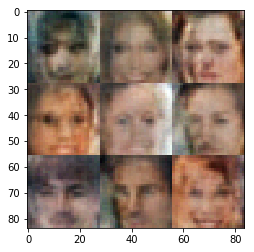

Step: 4210: Epoch 1/1... Discriminator Loss: 0.0150... Generator Loss: 7.5101
Step: 4220: Epoch 1/1... Discriminator Loss: 0.0071... Generator Loss: 7.6794
Step: 4230: Epoch 1/1... Discriminator Loss: 0.0230... Generator Loss: 7.8941
Step: 4240: Epoch 1/1... Discriminator Loss: 0.1663... Generator Loss: 2.4914
Step: 4250: Epoch 1/1... Discriminator Loss: 0.0067... Generator Loss: 6.8709
Step: 4260: Epoch 1/1... Discriminator Loss: 0.0029... Generator Loss: 7.9162
Step: 4270: Epoch 1/1... Discriminator Loss: 0.2146... Generator Loss: 2.2333
Step: 4280: Epoch 1/1... Discriminator Loss: 0.4458... Generator Loss: 1.3827
Step: 4290: Epoch 1/1... Discriminator Loss: 0.0214... Generator Loss: 14.4454
Step: 4300: Epoch 1/1... Discriminator Loss: 0.0116... Generator Loss: 12.0584


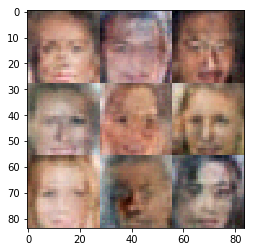

Step: 4310: Epoch 1/1... Discriminator Loss: 0.0190... Generator Loss: 4.2991
Step: 4320: Epoch 1/1... Discriminator Loss: 0.0370... Generator Loss: 12.0990
Step: 4330: Epoch 1/1... Discriminator Loss: 0.0296... Generator Loss: 4.7623
Step: 4340: Epoch 1/1... Discriminator Loss: 0.0028... Generator Loss: 13.7402
Step: 4350: Epoch 1/1... Discriminator Loss: 0.1929... Generator Loss: 2.0787
Step: 4360: Epoch 1/1... Discriminator Loss: 0.0044... Generator Loss: 10.2813
Step: 4370: Epoch 1/1... Discriminator Loss: 0.0295... Generator Loss: 4.0917
Step: 4380: Epoch 1/1... Discriminator Loss: 0.0054... Generator Loss: 13.5360
Step: 4390: Epoch 1/1... Discriminator Loss: 0.2984... Generator Loss: 1.7306
Step: 4400: Epoch 1/1... Discriminator Loss: 0.0032... Generator Loss: 15.9064


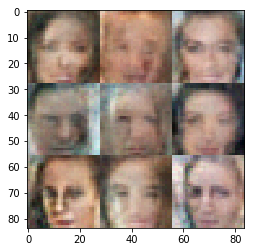

Step: 4410: Epoch 1/1... Discriminator Loss: 0.0208... Generator Loss: 7.3224
Step: 4420: Epoch 1/1... Discriminator Loss: 0.0070... Generator Loss: 9.4303
Step: 4430: Epoch 1/1... Discriminator Loss: 0.0048... Generator Loss: 11.1881
Step: 4440: Epoch 1/1... Discriminator Loss: 0.0102... Generator Loss: 5.2621
Step: 4450: Epoch 1/1... Discriminator Loss: 0.9101... Generator Loss: 0.7460
Step: 4460: Epoch 1/1... Discriminator Loss: 0.0100... Generator Loss: 5.1289
Step: 4470: Epoch 1/1... Discriminator Loss: 0.8258... Generator Loss: 3.0702
Step: 4480: Epoch 1/1... Discriminator Loss: 0.0234... Generator Loss: 4.5820
Step: 4490: Epoch 1/1... Discriminator Loss: 0.1562... Generator Loss: 3.0320
Step: 4500: Epoch 1/1... Discriminator Loss: 0.1947... Generator Loss: 2.3053


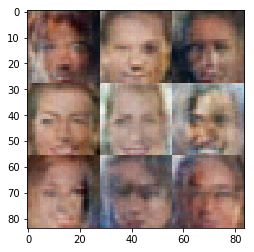

Step: 4510: Epoch 1/1... Discriminator Loss: 0.1190... Generator Loss: 3.0106
Step: 4520: Epoch 1/1... Discriminator Loss: 0.0092... Generator Loss: 8.1912
Step: 4530: Epoch 1/1... Discriminator Loss: 1.2744... Generator Loss: 0.4707
Step: 4540: Epoch 1/1... Discriminator Loss: 0.0068... Generator Loss: 8.2480
Step: 4550: Epoch 1/1... Discriminator Loss: 0.0084... Generator Loss: 10.4940
Step: 4560: Epoch 1/1... Discriminator Loss: 0.0158... Generator Loss: 4.8666
Step: 4570: Epoch 1/1... Discriminator Loss: 0.8447... Generator Loss: 0.7941
Step: 4580: Epoch 1/1... Discriminator Loss: 0.2666... Generator Loss: 7.7134
Step: 4590: Epoch 1/1... Discriminator Loss: 0.0864... Generator Loss: 3.4018
Step: 4600: Epoch 1/1... Discriminator Loss: 0.0196... Generator Loss: 12.1808


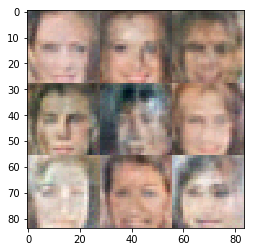

Step: 4610: Epoch 1/1... Discriminator Loss: 0.0283... Generator Loss: 4.7006
Step: 4620: Epoch 1/1... Discriminator Loss: 0.0801... Generator Loss: 3.3057
Step: 4630: Epoch 1/1... Discriminator Loss: 0.1290... Generator Loss: 2.4862
Step: 4640: Epoch 1/1... Discriminator Loss: 0.0125... Generator Loss: 7.2407
Step: 4650: Epoch 1/1... Discriminator Loss: 0.0144... Generator Loss: 7.5804
Step: 4660: Epoch 1/1... Discriminator Loss: 0.0705... Generator Loss: 3.2456
Step: 4670: Epoch 1/1... Discriminator Loss: 0.0192... Generator Loss: 5.8495
Step: 4680: Epoch 1/1... Discriminator Loss: 0.0101... Generator Loss: 7.8226
Step: 4690: Epoch 1/1... Discriminator Loss: 0.0024... Generator Loss: 7.9521
Step: 4700: Epoch 1/1... Discriminator Loss: 0.0199... Generator Loss: 5.2710


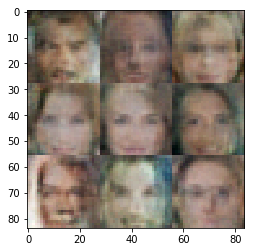

Step: 4710: Epoch 1/1... Discriminator Loss: 0.0793... Generator Loss: 9.3980
Step: 4720: Epoch 1/1... Discriminator Loss: 0.0020... Generator Loss: 9.3984
Step: 4730: Epoch 1/1... Discriminator Loss: 0.0010... Generator Loss: 14.2008
Step: 4740: Epoch 1/1... Discriminator Loss: 0.3974... Generator Loss: 1.5891
Step: 4750: Epoch 1/1... Discriminator Loss: 0.1407... Generator Loss: 2.6958
Step: 4760: Epoch 1/1... Discriminator Loss: 0.0223... Generator Loss: 9.4672
Step: 4770: Epoch 1/1... Discriminator Loss: 0.1899... Generator Loss: 2.3867
Step: 4780: Epoch 1/1... Discriminator Loss: 0.2628... Generator Loss: 2.1444
Step: 4790: Epoch 1/1... Discriminator Loss: 0.0232... Generator Loss: 9.3942
Step: 4800: Epoch 1/1... Discriminator Loss: 0.2439... Generator Loss: 1.8206


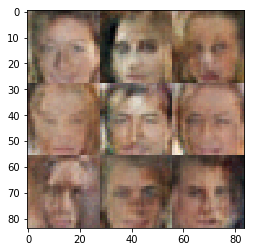

Step: 4810: Epoch 1/1... Discriminator Loss: 0.0018... Generator Loss: 7.5138
Step: 4820: Epoch 1/1... Discriminator Loss: 0.1195... Generator Loss: 2.9537
Step: 4830: Epoch 1/1... Discriminator Loss: 0.2990... Generator Loss: 1.8038
Step: 4840: Epoch 1/1... Discriminator Loss: 0.0173... Generator Loss: 9.7221
Step: 4850: Epoch 1/1... Discriminator Loss: 0.0389... Generator Loss: 4.6097
Step: 4860: Epoch 1/1... Discriminator Loss: 0.0293... Generator Loss: 11.1822
Step: 4870: Epoch 1/1... Discriminator Loss: 0.3218... Generator Loss: 1.5842
Step: 4880: Epoch 1/1... Discriminator Loss: 0.0058... Generator Loss: 11.2749
Step: 4890: Epoch 1/1... Discriminator Loss: 0.0161... Generator Loss: 10.4722
Step: 4900: Epoch 1/1... Discriminator Loss: 0.0142... Generator Loss: 11.8656


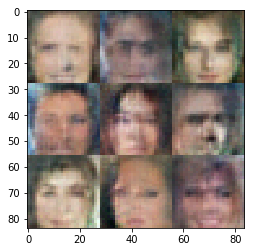

Step: 4910: Epoch 1/1... Discriminator Loss: 0.0290... Generator Loss: 5.4270
Step: 4920: Epoch 1/1... Discriminator Loss: 0.0167... Generator Loss: 11.0437
Step: 4930: Epoch 1/1... Discriminator Loss: 0.0028... Generator Loss: 14.7097
Step: 4940: Epoch 1/1... Discriminator Loss: 0.0092... Generator Loss: 6.6814
Step: 4950: Epoch 1/1... Discriminator Loss: 0.1927... Generator Loss: 2.1957
Step: 4960: Epoch 1/1... Discriminator Loss: 0.0033... Generator Loss: 7.7246
Step: 4970: Epoch 1/1... Discriminator Loss: 0.0261... Generator Loss: 5.3566
Step: 4980: Epoch 1/1... Discriminator Loss: 0.1350... Generator Loss: 2.4342
Step: 4990: Epoch 1/1... Discriminator Loss: 0.0020... Generator Loss: 9.8406
Step: 5000: Epoch 1/1... Discriminator Loss: 0.0032... Generator Loss: 11.9200


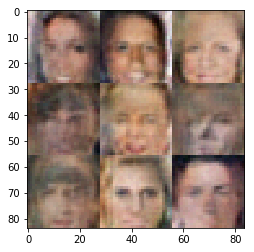

Step: 5010: Epoch 1/1... Discriminator Loss: 0.0029... Generator Loss: 12.3105
Step: 5020: Epoch 1/1... Discriminator Loss: 0.0075... Generator Loss: 11.6489
Step: 5030: Epoch 1/1... Discriminator Loss: 0.4289... Generator Loss: 1.3805
Step: 5040: Epoch 1/1... Discriminator Loss: 0.2337... Generator Loss: 1.7864
Step: 5050: Epoch 1/1... Discriminator Loss: 0.0067... Generator Loss: 12.2650
Step: 5060: Epoch 1/1... Discriminator Loss: 0.0037... Generator Loss: 7.7382
Step: 5070: Epoch 1/1... Discriminator Loss: 0.0223... Generator Loss: 4.5130
Step: 5080: Epoch 1/1... Discriminator Loss: 0.0053... Generator Loss: 11.5201
Step: 5090: Epoch 1/1... Discriminator Loss: 0.8477... Generator Loss: 1.2656
Step: 5100: Epoch 1/1... Discriminator Loss: 0.1181... Generator Loss: 3.1317


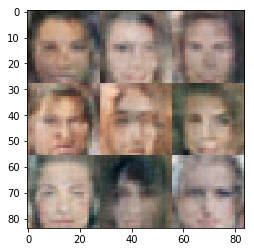

Step: 5110: Epoch 1/1... Discriminator Loss: 0.3418... Generator Loss: 3.3388
Step: 5120: Epoch 1/1... Discriminator Loss: 0.2733... Generator Loss: 1.7811
Step: 5130: Epoch 1/1... Discriminator Loss: 0.0190... Generator Loss: 6.2500
Step: 5140: Epoch 1/1... Discriminator Loss: 0.1533... Generator Loss: 4.7230
Step: 5150: Epoch 1/1... Discriminator Loss: 0.2884... Generator Loss: 2.9048
Step: 5160: Epoch 1/1... Discriminator Loss: 0.0369... Generator Loss: 5.9749
Step: 5170: Epoch 1/1... Discriminator Loss: 0.0393... Generator Loss: 7.4923
Step: 5180: Epoch 1/1... Discriminator Loss: 0.0166... Generator Loss: 7.5017
Step: 5190: Epoch 1/1... Discriminator Loss: 0.0080... Generator Loss: 8.2565
Step: 5200: Epoch 1/1... Discriminator Loss: 0.0080... Generator Loss: 9.8150


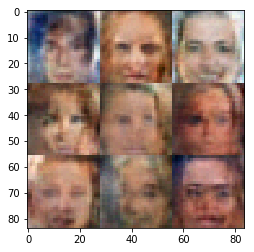

Step: 5210: Epoch 1/1... Discriminator Loss: 0.0363... Generator Loss: 5.7365
Step: 5220: Epoch 1/1... Discriminator Loss: 0.0453... Generator Loss: 3.6901
Step: 5230: Epoch 1/1... Discriminator Loss: 0.0164... Generator Loss: 12.4793
Step: 5240: Epoch 1/1... Discriminator Loss: 0.0120... Generator Loss: 14.2353
Step: 5250: Epoch 1/1... Discriminator Loss: 0.0123... Generator Loss: 10.2588
Step: 5260: Epoch 1/1... Discriminator Loss: 0.0242... Generator Loss: 4.6729
Step: 5270: Epoch 1/1... Discriminator Loss: 0.0060... Generator Loss: 11.2585
Step: 5280: Epoch 1/1... Discriminator Loss: 0.0394... Generator Loss: 4.0850
Step: 5290: Epoch 1/1... Discriminator Loss: 0.0034... Generator Loss: 13.9865
Step: 5300: Epoch 1/1... Discriminator Loss: 0.1429... Generator Loss: 2.6782


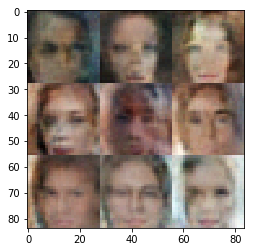

Step: 5310: Epoch 1/1... Discriminator Loss: 0.0254... Generator Loss: 14.5607
Step: 5320: Epoch 1/1... Discriminator Loss: 0.0189... Generator Loss: 10.0725
Step: 5330: Epoch 1/1... Discriminator Loss: 0.0082... Generator Loss: 10.3117
Step: 5340: Epoch 1/1... Discriminator Loss: 0.0017... Generator Loss: 14.4554
Step: 5350: Epoch 1/1... Discriminator Loss: 0.0440... Generator Loss: 4.1034
Step: 5360: Epoch 1/1... Discriminator Loss: 0.0176... Generator Loss: 6.7599
Step: 5370: Epoch 1/1... Discriminator Loss: 0.0021... Generator Loss: 10.2778
Step: 5380: Epoch 1/1... Discriminator Loss: 0.0129... Generator Loss: 9.0745
Step: 5390: Epoch 1/1... Discriminator Loss: 0.0374... Generator Loss: 4.3482
Step: 5400: Epoch 1/1... Discriminator Loss: 0.0018... Generator Loss: 8.5884


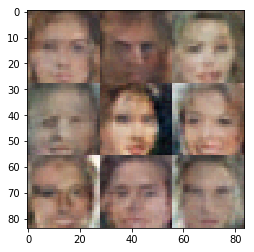

Step: 5410: Epoch 1/1... Discriminator Loss: 0.5344... Generator Loss: 1.0867
Step: 5420: Epoch 1/1... Discriminator Loss: 0.0090... Generator Loss: 8.1984
Step: 5430: Epoch 1/1... Discriminator Loss: 0.2381... Generator Loss: 1.8406
Step: 5440: Epoch 1/1... Discriminator Loss: 0.0112... Generator Loss: 8.0757
Step: 5450: Epoch 1/1... Discriminator Loss: 0.1572... Generator Loss: 2.2470
Step: 5460: Epoch 1/1... Discriminator Loss: 0.0038... Generator Loss: 8.0495
Step: 5470: Epoch 1/1... Discriminator Loss: 0.0135... Generator Loss: 6.7991
Step: 5480: Epoch 1/1... Discriminator Loss: 0.0197... Generator Loss: 11.9279
Step: 5490: Epoch 1/1... Discriminator Loss: 0.3506... Generator Loss: 12.7012
Step: 5500: Epoch 1/1... Discriminator Loss: 0.0011... Generator Loss: 11.0651


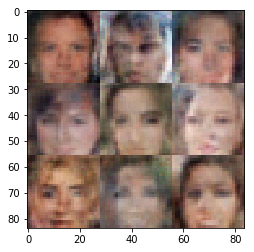

Step: 5510: Epoch 1/1... Discriminator Loss: 0.0088... Generator Loss: 6.2844
Step: 5520: Epoch 1/1... Discriminator Loss: 0.0173... Generator Loss: 4.7677
Step: 5530: Epoch 1/1... Discriminator Loss: 0.0370... Generator Loss: 4.5414
Step: 5540: Epoch 1/1... Discriminator Loss: 0.9087... Generator Loss: 0.7067
Step: 5550: Epoch 1/1... Discriminator Loss: 0.0001... Generator Loss: 13.6361
Step: 5560: Epoch 1/1... Discriminator Loss: 0.0118... Generator Loss: 7.0327
Step: 5570: Epoch 1/1... Discriminator Loss: 0.0034... Generator Loss: 8.8824
Step: 5580: Epoch 1/1... Discriminator Loss: 0.0038... Generator Loss: 8.9675
Step: 5590: Epoch 1/1... Discriminator Loss: 0.1381... Generator Loss: 2.6689
Step: 5600: Epoch 1/1... Discriminator Loss: 0.0074... Generator Loss: 10.2670


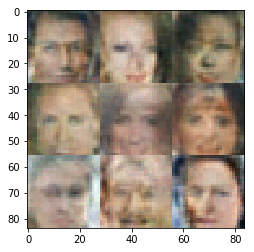

Step: 5610: Epoch 1/1... Discriminator Loss: 0.3656... Generator Loss: 1.4325
Step: 5620: Epoch 1/1... Discriminator Loss: 0.0130... Generator Loss: 13.4234
Step: 5630: Epoch 1/1... Discriminator Loss: 0.9987... Generator Loss: 0.6674
Step: 5640: Epoch 1/1... Discriminator Loss: 0.9403... Generator Loss: 0.7020
Step: 5650: Epoch 1/1... Discriminator Loss: 2.0165... Generator Loss: 7.9682
Step: 5660: Epoch 1/1... Discriminator Loss: 1.1537... Generator Loss: 0.5334
Step: 5670: Epoch 1/1... Discriminator Loss: 0.3847... Generator Loss: 1.5394
Step: 5680: Epoch 1/1... Discriminator Loss: 0.1183... Generator Loss: 12.8348
Step: 5690: Epoch 1/1... Discriminator Loss: 0.0242... Generator Loss: 8.3976
Step: 5700: Epoch 1/1... Discriminator Loss: 0.0112... Generator Loss: 7.1649


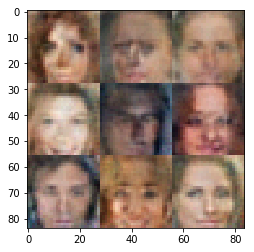

Step: 5710: Epoch 1/1... Discriminator Loss: 0.0145... Generator Loss: 7.5031
Step: 5720: Epoch 1/1... Discriminator Loss: 0.5864... Generator Loss: 1.1094
Step: 5730: Epoch 1/1... Discriminator Loss: 0.1758... Generator Loss: 7.7080
Step: 5740: Epoch 1/1... Discriminator Loss: 0.0064... Generator Loss: 8.9030
Step: 5750: Epoch 1/1... Discriminator Loss: 0.0058... Generator Loss: 10.0158
Step: 5760: Epoch 1/1... Discriminator Loss: 0.8036... Generator Loss: 0.7984
Step: 5770: Epoch 1/1... Discriminator Loss: 0.0351... Generator Loss: 4.4069
Step: 5780: Epoch 1/1... Discriminator Loss: 0.0458... Generator Loss: 11.7232
Step: 5790: Epoch 1/1... Discriminator Loss: 0.0109... Generator Loss: 6.1070
Step: 5800: Epoch 1/1... Discriminator Loss: 0.0140... Generator Loss: 4.9730


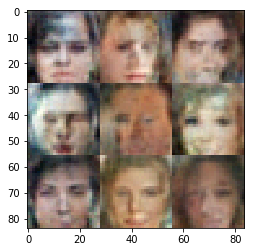

Step: 5810: Epoch 1/1... Discriminator Loss: 0.0058... Generator Loss: 6.4270
Step: 5820: Epoch 1/1... Discriminator Loss: 0.0355... Generator Loss: 4.0037
Step: 5830: Epoch 1/1... Discriminator Loss: 0.0155... Generator Loss: 6.3005
Step: 5840: Epoch 1/1... Discriminator Loss: 0.0125... Generator Loss: 5.2990
Step: 5850: Epoch 1/1... Discriminator Loss: 0.0154... Generator Loss: 7.9457
Step: 5860: Epoch 1/1... Discriminator Loss: 0.0136... Generator Loss: 5.1089
Step: 5870: Epoch 1/1... Discriminator Loss: 0.0013... Generator Loss: 10.8402
Step: 5880: Epoch 1/1... Discriminator Loss: 0.0110... Generator Loss: 11.8709
Step: 5890: Epoch 1/1... Discriminator Loss: 0.1179... Generator Loss: 2.5957
Step: 5900: Epoch 1/1... Discriminator Loss: 0.0100... Generator Loss: 7.7078


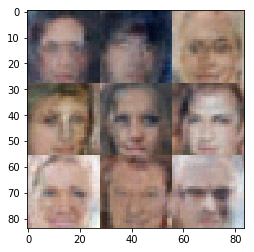

Step: 5910: Epoch 1/1... Discriminator Loss: 0.0068... Generator Loss: 6.0542
Step: 5920: Epoch 1/1... Discriminator Loss: 0.0046... Generator Loss: 7.7767
Step: 5930: Epoch 1/1... Discriminator Loss: 0.0144... Generator Loss: 10.5777
Step: 5940: Epoch 1/1... Discriminator Loss: 0.0024... Generator Loss: 8.8332
Step: 5950: Epoch 1/1... Discriminator Loss: 0.0024... Generator Loss: 10.1870
Step: 5960: Epoch 1/1... Discriminator Loss: 0.0263... Generator Loss: 5.3439
Step: 5970: Epoch 1/1... Discriminator Loss: 0.6183... Generator Loss: 0.9850
Step: 5980: Epoch 1/1... Discriminator Loss: 0.0070... Generator Loss: 10.6198
Step: 5990: Epoch 1/1... Discriminator Loss: 7.0873... Generator Loss: 15.4091
Step: 6000: Epoch 1/1... Discriminator Loss: 0.8352... Generator Loss: 4.6254


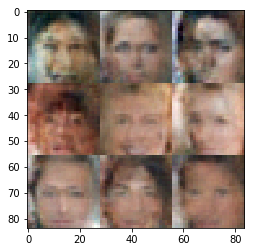

Step: 6010: Epoch 1/1... Discriminator Loss: 0.0251... Generator Loss: 4.7384
Step: 6020: Epoch 1/1... Discriminator Loss: 0.0682... Generator Loss: 6.1587
Step: 6030: Epoch 1/1... Discriminator Loss: 0.0418... Generator Loss: 6.8964
Step: 6040: Epoch 1/1... Discriminator Loss: 0.0136... Generator Loss: 4.8167
Step: 6050: Epoch 1/1... Discriminator Loss: 0.4082... Generator Loss: 1.4040
Step: 6060: Epoch 1/1... Discriminator Loss: 0.0073... Generator Loss: 14.0558
Step: 6070: Epoch 1/1... Discriminator Loss: 0.0095... Generator Loss: 8.6731
Step: 6080: Epoch 1/1... Discriminator Loss: 0.0087... Generator Loss: 10.6579
Step: 6090: Epoch 1/1... Discriminator Loss: 0.0779... Generator Loss: 3.0582
Step: 6100: Epoch 1/1... Discriminator Loss: 0.0254... Generator Loss: 4.6001


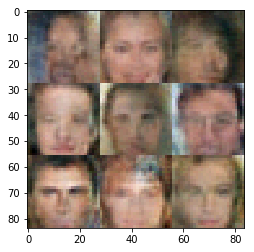

Step: 6110: Epoch 1/1... Discriminator Loss: 0.0232... Generator Loss: 6.1076
Step: 6120: Epoch 1/1... Discriminator Loss: 0.0027... Generator Loss: 7.6213
Step: 6130: Epoch 1/1... Discriminator Loss: 0.0058... Generator Loss: 14.2409
Step: 6140: Epoch 1/1... Discriminator Loss: 0.1975... Generator Loss: 5.0424
Step: 6150: Epoch 1/1... Discriminator Loss: 0.2596... Generator Loss: 2.3632
Step: 6160: Epoch 1/1... Discriminator Loss: 0.0357... Generator Loss: 4.0792
Step: 6170: Epoch 1/1... Discriminator Loss: 0.0357... Generator Loss: 4.1402
Step: 6180: Epoch 1/1... Discriminator Loss: 0.3625... Generator Loss: 4.7555
Step: 6190: Epoch 1/1... Discriminator Loss: 0.1022... Generator Loss: 7.6141
Step: 6200: Epoch 1/1... Discriminator Loss: 0.8217... Generator Loss: 0.8140


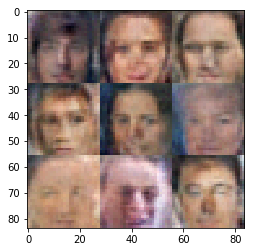

Step: 6210: Epoch 1/1... Discriminator Loss: 2.1301... Generator Loss: 0.2969
Step: 6220: Epoch 1/1... Discriminator Loss: 1.2003... Generator Loss: 0.5988
Step: 6230: Epoch 1/1... Discriminator Loss: 0.0117... Generator Loss: 7.6806
Step: 6240: Epoch 1/1... Discriminator Loss: 0.0269... Generator Loss: 5.9566
Step: 6250: Epoch 1/1... Discriminator Loss: 0.0053... Generator Loss: 10.2638
Step: 6260: Epoch 1/1... Discriminator Loss: 0.7254... Generator Loss: 0.9353
Step: 6270: Epoch 1/1... Discriminator Loss: 0.0110... Generator Loss: 13.0975
Step: 6280: Epoch 1/1... Discriminator Loss: 0.2057... Generator Loss: 1.9588
Step: 6290: Epoch 1/1... Discriminator Loss: 0.0379... Generator Loss: 11.6690
Step: 6300: Epoch 1/1... Discriminator Loss: 0.0109... Generator Loss: 7.3385


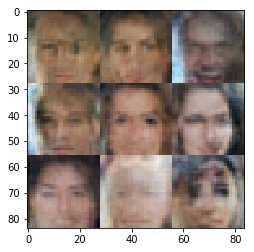

Step: 6310: Epoch 1/1... Discriminator Loss: 0.1927... Generator Loss: 2.2909
Step: 6320: Epoch 1/1... Discriminator Loss: 0.0336... Generator Loss: 5.2088
Step: 6330: Epoch 1/1... Discriminator Loss: 0.0124... Generator Loss: 7.6432


In [30]:
batch_size = 32
z_dim = 200
learning_rate = 0.0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.